# Предобработка данных

In [1]:
#!pip install catboost
#!pip install scikeras

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import lightgbm as lgb
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, label_ranking_average_precision_score, roc_curve, auc
from catboost import CatBoostClassifier
from PIL import Image
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, LSTM, Dense
from keras.optimizers import Adam
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# считываем X_train
X_train = pd.read_csv("X_train.csv")
X_train

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0
...,...,...,...,...,...,...,...,...,...,...
105104,0.017608,62,0,0.184589,9928.125255,6,0,2,0,0.0
105105,0.980631,25,0,0.158753,2187.355843,3,0,0,0,0.0
105106,0.050256,73,1,0.849711,3961.841113,12,0,2,0,0.0
105107,0.447882,43,0,0.068033,3705.546719,4,0,0,1,0.0


In [4]:
# Проверим наличие строк со значениями NaN
X_train.isnull().sum()

credit_card_utilization           0
age                               0
overdue_30_59_days                0
debt_to_income                    0
monthly_income                20993
credits_loans                     0
overdue__more_than_90_days        0
mortgage_loans                    0
overdue_60_89_days                0
family_members                 2805
dtype: int64

Закомментирован один из вариантов заполнения пропусков (оказался менее эффективным)

In [ ]:
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# # Создание объекта IterativeImputer
# imputer = IterativeImputer()

# # Заполнение пропущенных значений
# X_train = imputer.fit_transform(X_train)

#X_train = pd.DataFrame(X_train, columns=column_names)

In [5]:
# Заполняем пропуски
X_train['family_members'] = X_train['family_members'].fillna(X_train['family_members'].dropna().median())
X_train['monthly_income'] = X_train['monthly_income'].fillna(X_train['monthly_income'].dropna().std())

Далее обрабатываются выбросы

In [6]:
X_train.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,105109.000000,105109.000000,105109.000000,105109.000000,1.051090e+05,105109.000000,105109.000000,105109.000000,105109.000000,105109.000000
mean,5.825173,53.321067,0.426643,354.188156,7.531578e+03,8.956255,0.269967,1.018514,0.244356,0.736892
std,251.021431,14.811007,4.251225,1827.184165,1.005472e+04,5.182715,4.227366,1.136228,4.214018,1.108264
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029592,42.000000,0.000000,0.173670,3.839548e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153792,53.000000,0.000000,0.365047,6.576455e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.554374,64.000000,0.000000,0.880882,1.106504e+04,12.000000,0.000000,2.000000,0.000000,1.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000


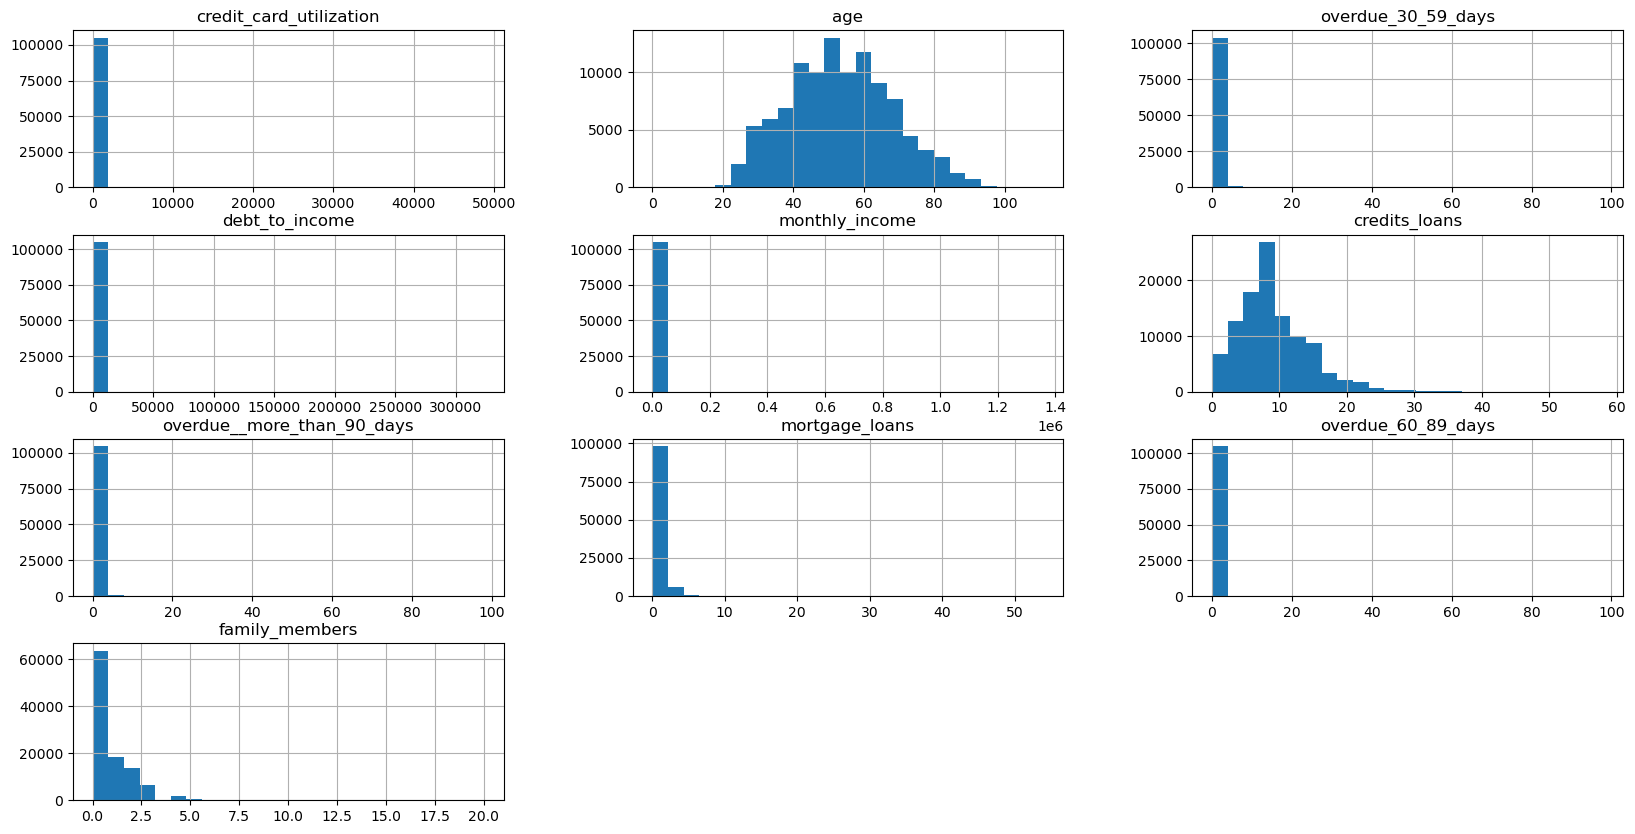

In [7]:
# Построим гистограммы для каждого признака и посмотрим на распределения
X_train.hist(figsize=(20,10), bins=25)
plt.show()

In [8]:
# Обработаем выбросы
X_train.loc[X_train['debt_to_income'] >= 1, 'debt_to_income'] = 1
X_train.loc[X_train['credit_card_utilization'] >= 1, 'credit_card_utilization'] = 1
X_train.loc[X_train['overdue_30_59_days'] >= 1, 'overdue_30_59_days'] = 1
X_train.loc[X_train['overdue_60_89_days'] >= 1, 'overdue_60_89_days'] = 1
X_train.loc[X_train['overdue__more_than_90_days'] >= 1, 'overdue__more_than_90_days'] = 1
X_train.loc[X_train['monthly_income'] >= 22000, 'monthly_income'] = 22000
X_train.loc[X_train['credits_loans'] >= 20, 'credits_loans'] = 20
X_train.loc[X_train['family_members'] >= 4, 'family_members'] = 4
X_train.loc[X_train['mortgage_loans'] >= 4, 'mortgage_loans'] = 4
X_train.loc[X_train['age'] >= 80, 'age'] = 80
X_train.loc[X_train['age'] <= 20, 'age'] = 20

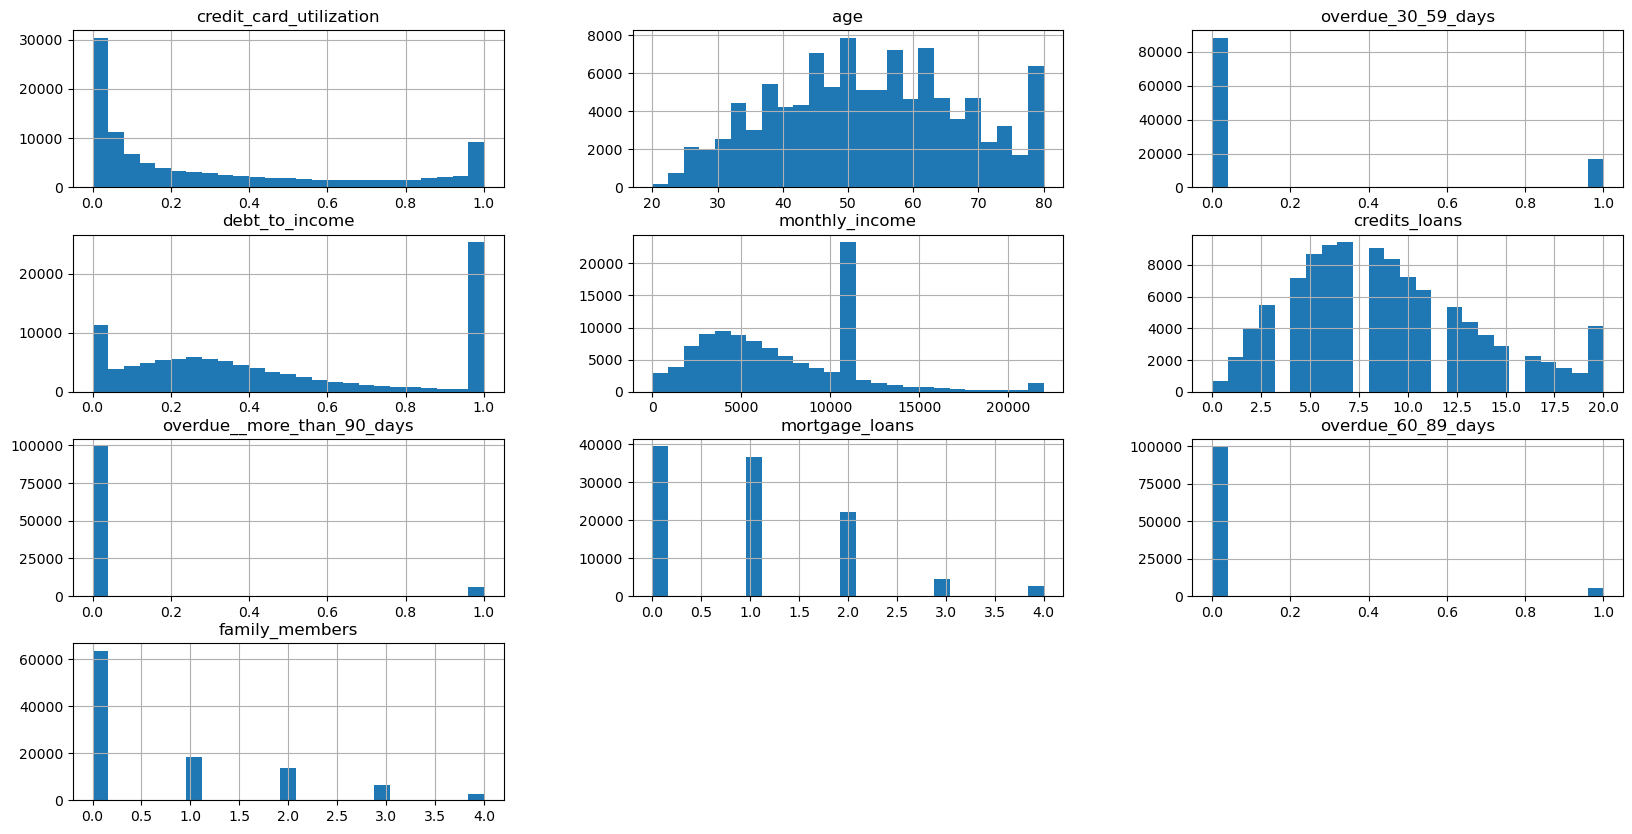

In [9]:
# Построим гистограммы для каждого признака и посмотрим на распределения
X_train.hist(figsize=(20,10), bins=25)
plt.show()

<AxesSubplot:>

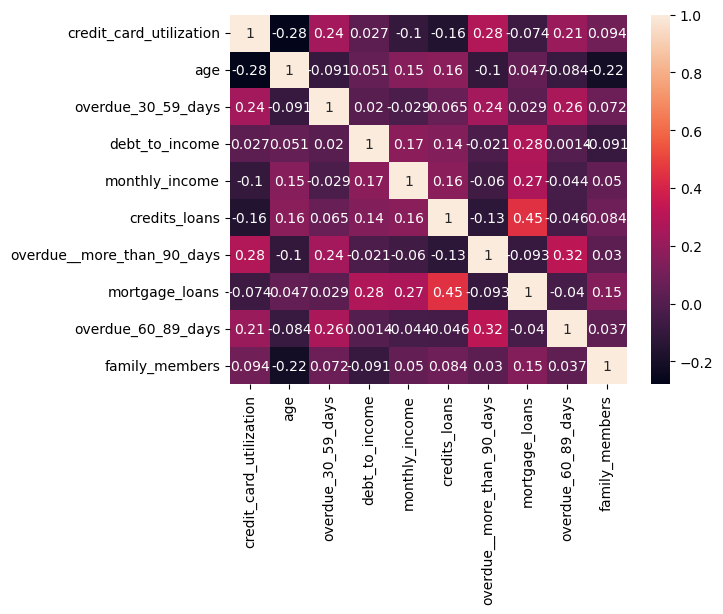

In [10]:
# Строим матрицу корреляций
sns.heatmap(X_train.corr(), annot = True)

In [11]:
# считываем y_train
y_train = pd.read_csv("y_train.csv")
y_train

,target
0,0
1,0
2,0
3,0
4,0
...,...
105104,0
105105,0
105106,0
105107,0


In [12]:
# считываем X_test
X_test = pd.read_csv("X_test.csv")
X_test

,index,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,143522,0.021069,60,0,0.184907,14403.715440,9,0,1,0,0.0
1,116747,0.009985,82,0,0.446264,6768.581963,6,0,3,0,0.0
2,66075,0.535187,43,1,0.406317,4686.080429,14,0,2,0,3.0
3,133292,0.051264,31,0,0.311893,3867.175176,8,0,0,0,1.0
4,83134,0.069525,45,0,0.294956,9869.273012,6,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
38871,44475,0.731740,39,0,0.251005,3474.894386,5,0,0,0,0.0
38872,103189,0.010959,70,0,0.152539,4170.426464,14,0,1,0,0.0
38873,48732,0.084612,52,0,5288.053772,NaN,15,0,2,0,0.0
38874,135410,0.741717,51,0,0.378356,5441.458787,9,0,2,0,0.0


In [13]:
# Сохраним индексы для вывода в файл
index = X_test['index']

In [14]:
# Проверим наличие строк со значениями NaN
X_test.isnull().sum()

index                            0
credit_card_utilization          0
age                              0
overdue_30_59_days               0
debt_to_income                   0
monthly_income                7545
credits_loans                    0
overdue__more_than_90_days       0
mortgage_loans                   0
overdue_60_89_days               0
family_members                 955
dtype: int64

In [15]:
# Заполним пропуски и удалим индекс
X_test['family_members'] = X_test['family_members'].fillna(X_test['family_members'].dropna().median())
X_test['monthly_income'] = X_test['monthly_income'].fillna(X_test['monthly_income'].dropna().std())
X_test = X_test.drop('index', axis=1)
X_test

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
0,0.021069,60,0,0.184907,14403.715440,9,0,1,0,0.0
1,0.009985,82,0,0.446264,6768.581963,6,0,3,0,0.0
2,0.535187,43,1,0.406317,4686.080429,14,0,2,0,3.0
3,0.051264,31,0,0.311893,3867.175176,8,0,0,0,1.0
4,0.069525,45,0,0.294956,9869.273012,6,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...
38871,0.731740,39,0,0.251005,3474.894386,5,0,0,0,0.0
38872,0.010959,70,0,0.152539,4170.426464,14,0,1,0,0.0
38873,0.084612,52,0,5288.053772,21160.508236,15,0,2,0,0.0
38874,0.741717,51,0,0.378356,5441.458787,9,0,2,0,0.0


Далее обрабатываются выбросы

In [16]:
X_test.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,38876.000000,38876.000000,38876.000000,38876.000000,3.887600e+04,38876.000000,38876.000000,38876.000000,38876.000000,38876.000000
mean,7.143140,53.236238,0.406986,351.627896,9.527533e+03,8.946599,0.252598,1.017466,0.229808,0.740483
std,259.023345,14.772393,4.023815,2545.254355,1.983563e+04,5.153647,3.999838,1.113531,3.985055,1.105342
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029097,42.000000,0.000000,0.170806,3.809213e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152136,53.000000,0.000000,0.361875,6.553651e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.558911,64.000000,0.000000,0.843592,1.331609e+04,12.000000,0.000000,2.000000,0.000000,1.000000
max,32131.063581,110.000000,98.000000,349464.845051,3.117341e+06,56.000000,98.000000,23.000000,98.000000,9.000000


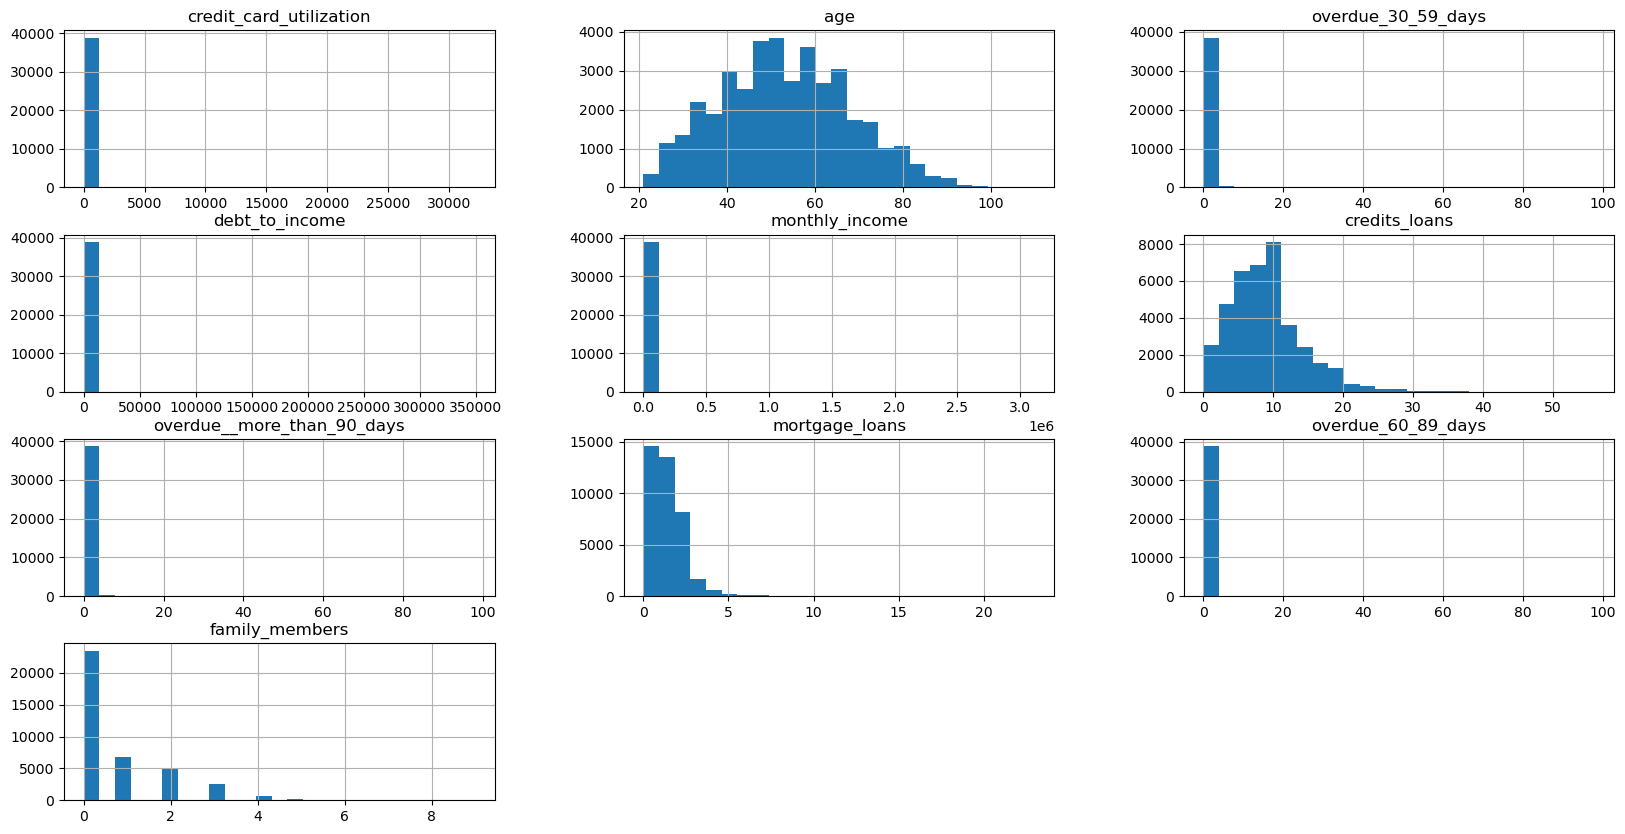

In [17]:
# Построим гистограммы для каждого признака и посмотрим на распределения
X_test.hist(figsize=(20,10), bins=25)
plt.show()

In [18]:
X_test.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,38876.000000,38876.000000,38876.000000,38876.000000,3.887600e+04,38876.000000,38876.000000,38876.000000,38876.000000,38876.000000
mean,7.143140,53.236238,0.406986,351.627896,9.527533e+03,8.946599,0.252598,1.017466,0.229808,0.740483
std,259.023345,14.772393,4.023815,2545.254355,1.983563e+04,5.153647,3.999838,1.113531,3.985055,1.105342
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029097,42.000000,0.000000,0.170806,3.809213e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152136,53.000000,0.000000,0.361875,6.553651e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.558911,64.000000,0.000000,0.843592,1.331609e+04,12.000000,0.000000,2.000000,0.000000,1.000000
max,32131.063581,110.000000,98.000000,349464.845051,3.117341e+06,56.000000,98.000000,23.000000,98.000000,9.000000


In [19]:
# Обработаем выбросы
X_test.loc[X_test['debt_to_income'] >= 1, 'debt_to_income'] = 1
X_test.loc[X_test['credit_card_utilization'] >= 1, 'credit_card_utilization'] = 1
X_test.loc[X_test['overdue_30_59_days'] >= 1, 'overdue_30_59_days'] = 1
X_test.loc[X_test['overdue_60_89_days'] >= 1, 'overdue_60_89_days'] = 1
X_test.loc[X_test['overdue__more_than_90_days'] >= 1, 'overdue__more_than_90_days'] = 1
X_test.loc[X_test['monthly_income'] >= 22000, 'monthly_income'] = 22000
X_test.loc[X_test['credits_loans'] >= 20, 'credits_loans'] = 20
X_test.loc[X_test['family_members'] >= 4, 'family_members'] = 4
X_test.loc[X_test['mortgage_loans'] >= 4, 'mortgage_loans'] = 4
X_test.loc[X_test['age'] >= 80, 'age'] = 80
X_test.loc[X_test['age'] <= 20, 'age'] = 20

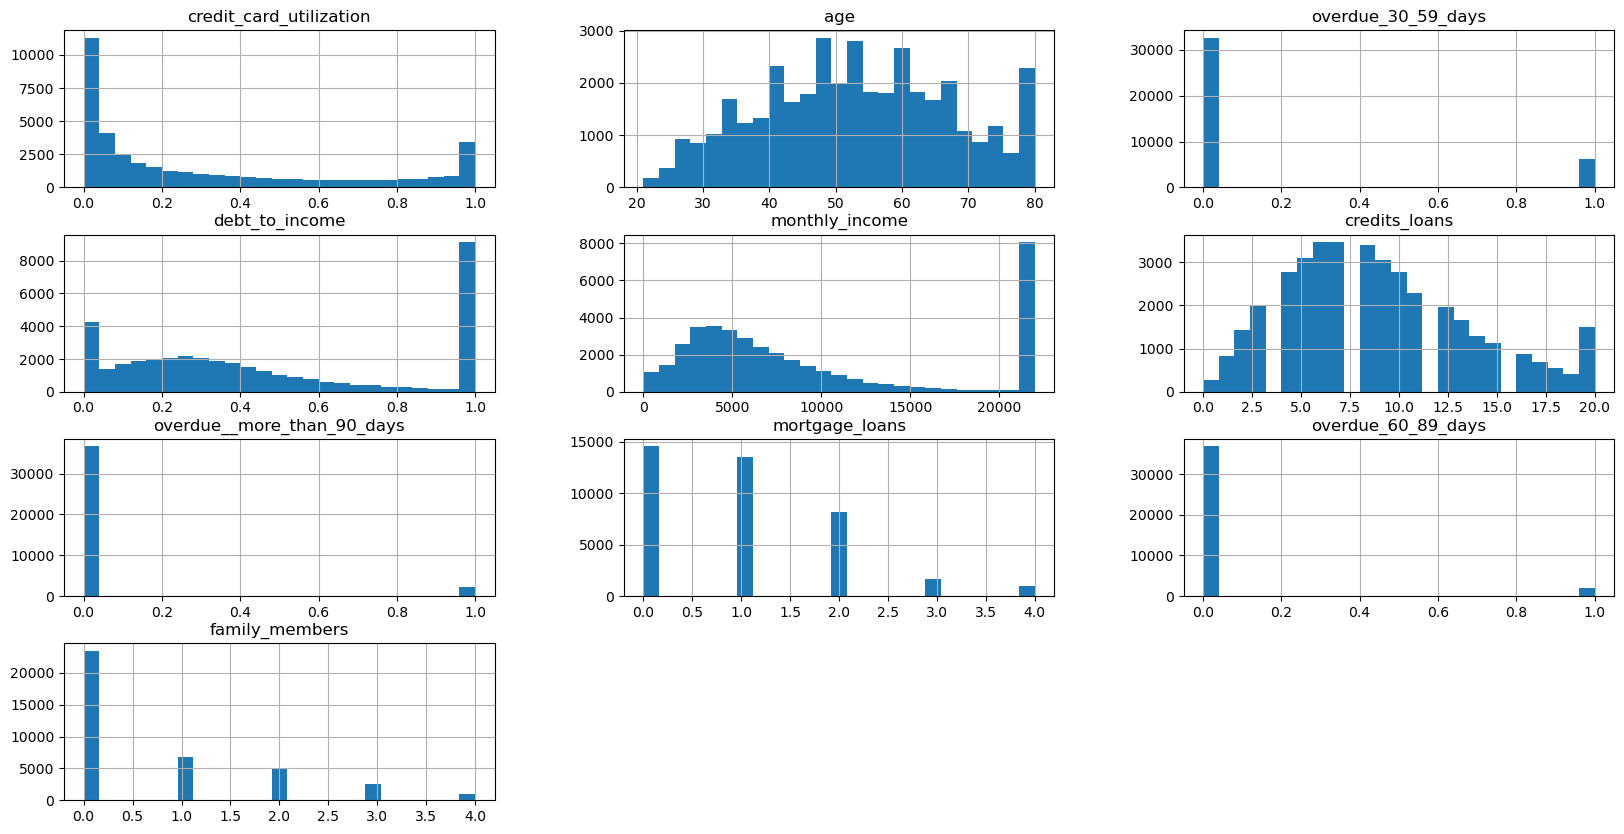

In [20]:
# Построим гистограммы для каждого признака и посмотрим на распределения
X_test.hist(figsize=(20,10), bins=25)
plt.show()

<AxesSubplot:>

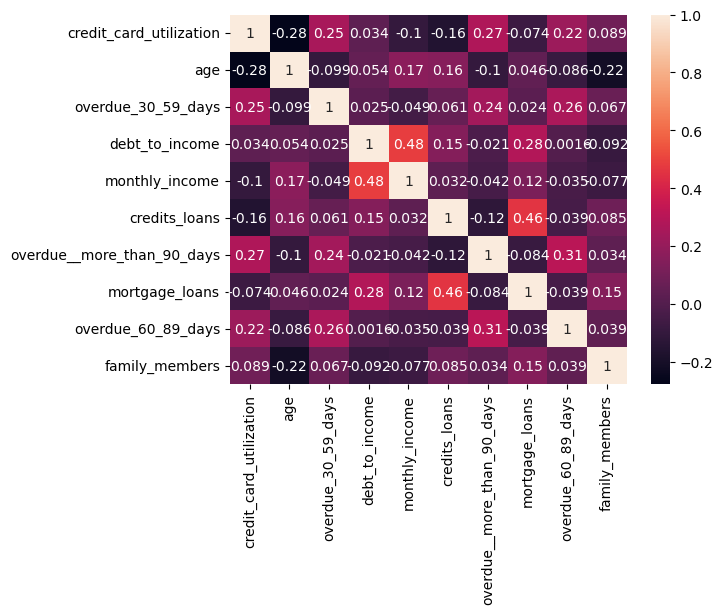

In [21]:
# Строим матрицу корреляций
sns.heatmap(X_test.corr(), annot = True)

Описание датасета:

В этой задаче вам даны исторические данные: набор из 10 признаков по заявкам на кредит. Для каждой заявки известно, была ли допущена просрочка по выплате кредита (target=1), или займ был возвращен вовремя (target=0).

Признаки одной заявки, которые есть в файлах X_train и X_test:

* age — возраст заемщика
* monthly_income — месячный доход заемщика
* credit_card_utilization — отношение баланса на счету к лимиту по кредиту
* debt_to_income — Debt-to-income Ratio
* credits_loans — текущее число займов и кредитных линий
* mortgage_loans — текущее количество ипотечных займов
* family_members — количество членов в семье заемщика
* overdue_30_59_days — число предыдущих просрочек выплат по кредиту от 30 до 59 дней
* overdue_60_89_days — число предыдущих просрочек выплат по кредиту от 60 до 89 дней
* overdue__more_than_90_days — число предыдущих просрочек выплат по кредиту более 90 дней
* target — была ли просрочки выплат по кредиту более 90 дней - имеется только в обучающей выборке

В файле y_train находятся ответы, была или нет просрочка (0 или 1) по факту

Далее происходит масштабирование данных и разделение на тренировочную и валидационную выборки

In [22]:
# Отделяем признаки от таргета
X = X_train
y = y_train

# Масштабируем признаки
scaler = StandardScaler()
X = scaler.fit_transform(X)

# разбиваем данные на обучающие и тестовые в соотношении 80/20
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# Обучение моделей

1. Logistic Regression

In [23]:
# Создание модели логистической регрессии
logistic_model = LogisticRegression()

# Задание сетки гиперпараметров для подбора
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Подбор оптимальных гиперпараметров для модели логистической регрессии
logistic_grid_search = GridSearchCV(logistic_model, param_grid=param_grid, scoring='roc_auc')
logistic_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [24]:
# Получение лучших моделей после подбора
best_logistic_model = logistic_grid_search.best_estimator_

# Прогнозирование вероятностей на тестовых данных
y_pred = best_logistic_model.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC для моделей
logistic_roc_auc = roc_auc_score(y_val, y_pred)

# Вывод метрик качества
print("Вероятности:\n")
print("Logistic Regression ROC-AUC:", logistic_roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*logistic_roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_logistic_model.predict(X_val)

# Вычисление ROC-AUC для моделей
logistic_roc_auc = roc_auc_score(y_val, y_pred)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Вероятности:

Logistic Regression ROC-AUC: 0.8593600473834849
Gini coefficient: 0.7187200947669699

Принадлежность к классу 0 или 1:

Accuracy: 0.9376843307011702
Precision: 0.5909090909090909
Recall: 0.1958393113342898
F1-score: 0.2941810344827586
ROC-AUC: 0.5931051050252047
Gini coefficient: 0.1862102100504095


In [25]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_logistic_model.predict_proba(X_test)[:,1]

# Создание датафрейма и сохранение результатов в файл
y_test_lr = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_lr.to_csv('y_test_lr.csv', index=False, encoding='utf-8')

In [26]:
# Список для хранения средних метрик качества по каждому количеству фолдов
sum_scores = []

# Выполнение кросс-валидации и оценка производительности модели
scores = cross_val_score(best_logistic_model, X_train, y_train, cv=10, scoring='roc_auc')

# Вывод метрик качества для каждого фолда
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ROC-AUC = {score}")
    sum_scores.append(score)
# Вывод средней метрики качества по всем фолдам
mean_score = scores.mean()
print("Mean ROC-AUC:", mean_score)

Fold 1: ROC-AUC = 0.8531165669961894
Fold 2: ROC-AUC = 0.86219584683744
Fold 3: ROC-AUC = 0.8492033142128744
Fold 4: ROC-AUC = 0.8427477862305576
Fold 5: ROC-AUC = 0.8457505571150254
Fold 6: ROC-AUC = 0.8572024915359197
Fold 7: ROC-AUC = 0.8482649200602091
Fold 8: ROC-AUC = 0.865361064225044
Fold 9: ROC-AUC = 0.8688757645636426
Fold 10: ROC-AUC = 0.8513152815371536
Mean ROC-AUC: 0.8544033593314057


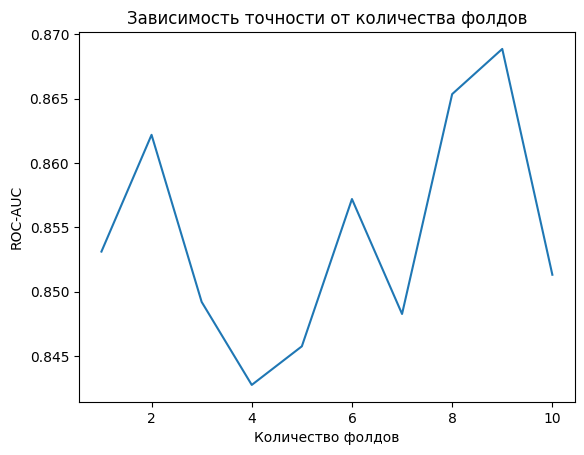

In [27]:
# Построение графика зависимости точности от количества фолдов
plt.plot(range(1,11), sum_scores)
plt.xlabel('Количество фолдов')
plt.ylabel('ROC-AUC')
plt.title('Зависимость точности от количества фолдов')
plt.show()

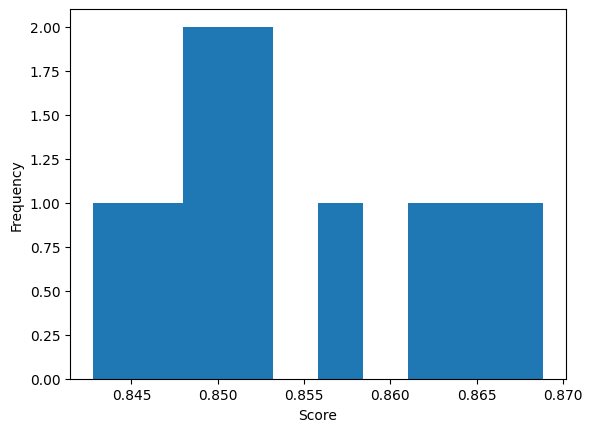

In [28]:
# построим распределение score
plt.hist(scores, bins=10)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

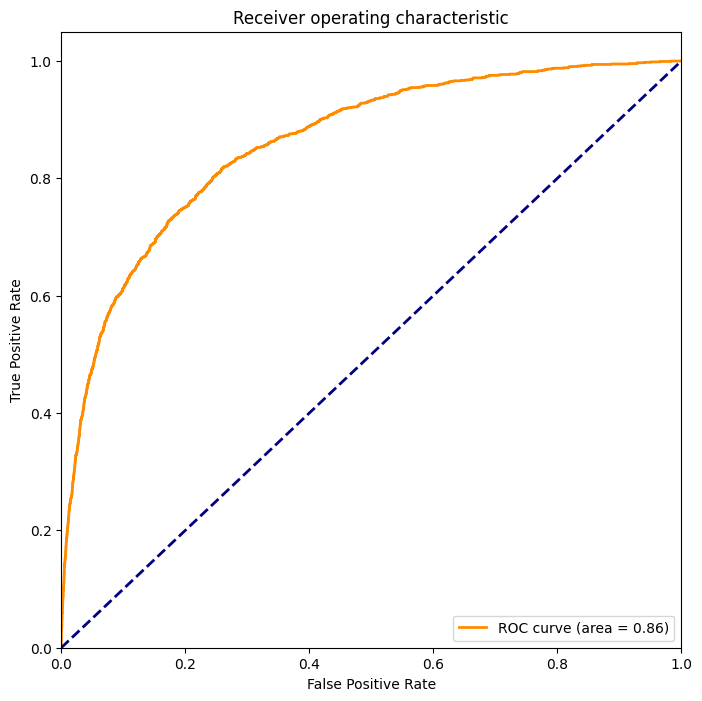

In [29]:
# Расчет AUC-ROC на тестовой выборке
y_pred_proba = best_logistic_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

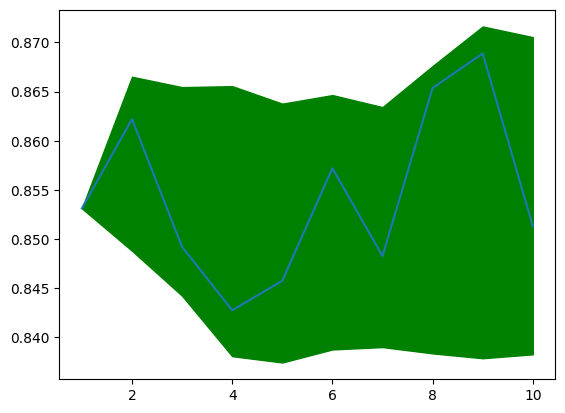

In [30]:
# Список для хранения средних метрик качества по каждому количеству фолдов
sum_scores = []
minimum = []
maximum = []

# Выполнение кросс-валидации и оценка производительности модели
scores = cross_val_score(best_logistic_model, X_train, y_train, cv=10, scoring='roc_auc')

# Вывод метрик качества для каждого фолда
for i, score in enumerate(scores):
    sum_scores.append(score.mean())
    minimum.append(pd.Series(sum_scores).mean() - 1.95 * np.std(pd.Series(sum_scores)))
    maximum.append(pd.Series(sum_scores).mean() + 1.95 * np.std(pd.Series(sum_scores)))

plt.plot(range(1, 11, 1),sum_scores)
plt.fill_between(range(1,11), minimum, maximum, color = 'green')
plt.show()

2. K Neighbors Classifier (KNN)

In [33]:
# Инициализируем дефолтную модель
x_kNN = KNeighborsClassifier()

# Инициализируем метрики
xTicks = ['chebyshev', 'manhattan']

# Подберём оптимальные параметры. Число соседей будем перебирать из диапазона от 1 до 51, чтобы избежать значений NaN
param_grid = {'n_neighbors': [50], 'metric': xTicks}

# Подберём наилучшие параметры для модели с помощью GridSearchCV. Для увеличения производительности значение n_jobs будет
# равно -1. Число фолдов будет равно 3
gsCV1 = GridSearchCV(x_kNN, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Обучим нашу модель
gsCV1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['chebyshev', 'manhattan'],
                         'n_neighbors': [50]},
             scoring='roc_auc')

In [34]:
best_knn_model = gsCV1.best_estimator_

# Предсказание на тестовых данных
y_pred = best_knn_model.predict_proba(X_val)[:,1]

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели KNN:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_knn_model.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
knn_roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", knn_roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*knn_roc_auc-1)

Метрики качества модели KNN:
Вероятности:

ROC-AUC: 0.8420308556949797
Gini coefficient: 0.6840617113899594

Принадлежность к классу 0 или 1:

Accuracy: 0.9380648844068119
Precision: 0.6314285714285715
Recall: 0.15853658536585366
F1-score: 0.25344036697247707
ROC-AUC: 0.5759821708162057
Gini coefficient: 0.15196434163241146


In [35]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_knn_model.predict_proba(X_test)[:,1]

# Создание датафрейма и сохранение результатов в файл
y_test_knn = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_knn.to_csv('y_test_knn.csv', index=False, encoding='utf-8')

3. SGD Classifier

In [38]:
# Инициализируем дефолтную модель
x_SGD = SGDClassifier()

# Инициализируем метрики
xTicks = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', \
          'epsilon_insensitive','none', 'l2', 'l1', 'elasticnet']

# Подберём оптимальные параметры
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', \
                       'epsilon_insensitive'], 'penalty': ['none', 'l2', 'l1', 'elasticnet']}

# Подберём наилучшие параметры для модели с помощью GridSearchCV. Число фолдов будет равно 3
gsCV2 = GridSearchCV(x_SGD, param_grid, scoring='roc_auc', cv=3)

# Обучим нашу модель
gsCV2.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron', 'squared_loss',
                                  'huber', 'epsilon_insensitive'],
                         'penalty': ['none', 'l2', 'l1', 'elasticnet']},
             scoring='roc_auc')

In [39]:
best_sgd_model = gsCV2.best_estimator_

# Предсказание на тестовых данных
y_pred = best_sgd_model.predict_proba(X_val)[:,1]

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели SGD:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_sgd_model.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели SGD:
Вероятности:

ROC-AUC: 0.8587259065972863
Gini coefficient: 0.7174518131945726

Принадлежность к классу 0 или 1:

Accuracy: 0.9362096850918086
Precision: 0.5419968304278923
Recall: 0.24533715925394547
F1-score: 0.3377777777777778
ROC-AUC: 0.6153066476930008
Gini coefficient: 0.23061329538600162


In [40]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_sgd_model.predict_proba(X_test)[:,1]

# Создание датафрейма и сохранение результатов в файл
y_test_sgd = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_sgd.to_csv('y_test_sgd.csv', index=False, encoding='utf-8')

4. Random Forest Classifier

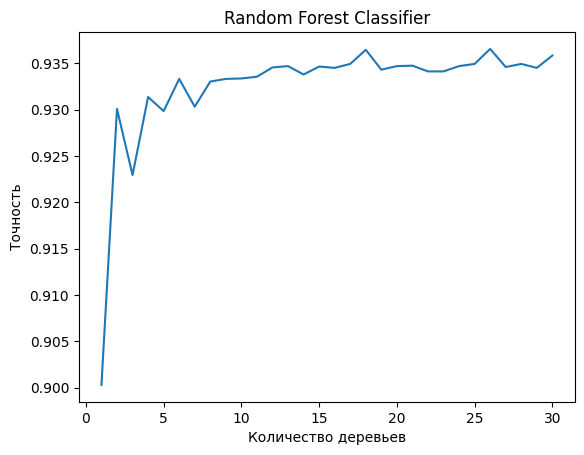

In [43]:
max_trees_number = 30
result = []

for current_trees_number in range(1,max_trees_number + 1):
    # инициализируем модель
    RFC_model = RandomForestClassifier(n_estimators=current_trees_number)
    # обучаем модель
    RFC_model.fit(X_train, y_train)
    # считаем скор
    score = RFC_model.score(X_val, y_val)
    # сохраняем скор
    result.append(score)

plt.plot(range(1,max_trees_number + 1), result)
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title('Random Forest Classifier')
plt.show()

In [45]:
result

[0.9002949291218724,
 0.9300732565883361,
 0.9229378746075539,
 0.9313576253448768,
 0.92983541052231,
 0.9333079630862906,
 0.9303111026543621,
 0.9330225478070593,
 0.9333079630862906,
 0.9333555322994957,
 0.9335458091523167,
 0.9345447626296262,
 0.9346874702692417,
 0.9337836552183427,
 0.9346399010560366,
 0.9344971934164209,
 0.9349253163352678,
 0.9364475311578346,
 0.9343069165636,
 0.9346874702692417,
 0.934735039482447,
 0.9341166397107792,
 0.9341166397107792,
 0.9346874702692417,
 0.9349253163352678,
 0.936542669584245,
 0.9345923318428313,
 0.9349253163352678,
 0.9344971934164209,
 0.9358291313861669]

In [51]:
# Инициализируем дефолтную модель
x_RFC = RandomForestClassifier()

# Инициализируем метрики
xTicks = ['auto', 'sqrt', 'log2', None, 'gini', 'entropy']

# Подберём оптимальные параметры
param_grid = {'n_estimators': [17], 'max_features': ['auto', 'sqrt', 'log2', None], 'criterion': ['gini', 'entropy']}

# Подберём наилучшие параметры для модели с помощью GridSearchCV. Число фолдов будет равно 5
gsCV3 = GridSearchCV(x_RFC, param_grid, scoring='roc_auc', cv=5)

# Обучим нашу модель
gsCV3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [17]},
             scoring='roc_auc')

In [52]:
best_rfc_model = gsCV3.best_estimator_

# Предсказание на тестовых данных
y_pred = best_rfc_model.predict_proba(X_val)[:,1]

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели RFC:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_rfc_model.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели RFC:
Вероятности:

ROC-AUC: 0.7915213282696607
Gini coefficient: 0.5830426565393214

Принадлежность к классу 0 или 1:

Accuracy: 0.9345923318428313
Precision: 0.5171790235081374
Recall: 0.20516499282639886
F1-score: 0.29378531073446323
ROC-AUC: 0.5957809883634745
Gini coefficient: 0.19156197672694897


In [53]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_rfc_model.predict_proba(X_test)[:,1]

# Создание датафрейма и сохранение результатов в файл
y_test_rfc = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_rfc.to_csv('y_test_rfc.csv', index=False, encoding='utf-8')

5. Decision Tree Classifier

In [56]:
# Создание модели дерева решений
x_DTC = DecisionTreeClassifier()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Поиск оптимальных гиперпараметров с использованием перекрестной проверки
grid_search = GridSearchCV(x_DTC, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Оптимальные гиперпараметры
best_params = grid_search.best_params_

# Создание модели дерева решений с оптимальными гиперпараметрами
decision_tree = DecisionTreeClassifier(**best_params)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=5)

In [57]:

# Предсказание на тестовых данных
y_pred = decision_tree.predict_proba(X_val)[:,1]

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели DTC:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_logistic_model.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели DTC:
Вероятности:

ROC-AUC: 0.8474725482204294
Gini coefficient: 0.6949450964408588

Принадлежность к классу 0 или 1:

Accuracy: 0.9376843307011702
Precision: 0.5909090909090909
Recall: 0.1958393113342898
F1-score: 0.2941810344827586
ROC-AUC: 0.5931051050252047
Gini coefficient: 0.1862102100504095


In [58]:
# Прогнозирование вероятностей на тестовых данных
y_test = decision_tree.predict_proba(X_test)[:,1]

# Создание датафрейма и сохранение результатов в файл
y_test_dtc = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_dtc.to_csv('y_test_dtc.csv', index=False, encoding='utf-8')

6. Gradient Boosting Classifier

In [61]:
# Создание и обучение модели градиентного бустинга
x_GBC = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 3, 5, 7]
}

gradient_boosting = GridSearchCV(x_GBC, param_grid, cv=5)
gradient_boosting.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1], 'max_depth': [1, 3, 5, 7],
                         'n_estimators': [10, 50, 100]})

In [62]:
gradient_boosting = gradient_boosting.best_estimator_

# Предсказание на тестовых данных
y_pred = gradient_boosting.predict_proba(X_val)[:,1]

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели GBC:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = gradient_boosting.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели GBC:
Вероятности:

ROC-AUC: 0.8626945402565187
Gini coefficient: 0.7253890805130374

Принадлежность к классу 0 или 1:

Accuracy: 0.9383978688992484
Precision: 0.6246851385390428
Recall: 0.17790530846484937
F1-score: 0.2769402568397543
ROC-AUC: 0.5851570561072974
Gini coefficient: 0.1703141122145948


In [63]:
# Прогнозирование вероятностей на тестовых данных
y_test = gradient_boosting.predict_proba(X_test)[:,1]

# Создание датафрейма и сохранение результатов в файл
y_test_gbc = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_gbc.to_csv('y_test_gbc.csv', index=False, encoding='utf-8')

7. Multilayer perceptron

In [ ]:
# Создание модели MLP
model_MLP = Sequential()
model_MLP.add(Dense(32, activation='relu', input_shape=(10,)))
model_MLP.add(Dense(32, activation='relu'))
model_MLP.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model_MLP.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model_MLP.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0)

In [ ]:
# Предсказание на тестовых данных
y_pred = model_MLP.predict(X_val)

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

print("\nПринадлежность к классу 0 или 1:\n")

y_pred = np.where(y_pred > 0.5, 1, 0)

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

657/657 [==============================] - 1s 1ms/step
Метрики качества модели:
Вероятности:

ROC-AUC: 0.8584986706836105
Gini coefficient: 0.716997341367221

Принадлежность к классу 0 или 1:

Accuracy: 0.9376843307011702
Precision: 0.6265060240963856
Recall: 0.1492109038737446
F1-score: 0.24101969872537657
ROC-AUC: 0.5714466991347529
Gini coefficient: 0.14289339826950576


In [ ]:
# # Прогнозирование вероятностей на тестовых данных
# y_test = model_MLP.predict(X_test)[:,1]

# # Создание датафрейма и сохранение результатов в файл
# y_test_MLP = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
# y_test_MLP.to_csv('y_test_MLP.csv', index=False, encoding='utf-8')

8. Recurrent neural network

In [ ]:
# Подготовка данных
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Создание модели LSTM
model_rnn = Sequential()
model_rnn.add(LSTM(32, input_shape=(1, 10), dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model_rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=64, verbose=0)

In [ ]:
# Предсказание вероятностей просрочки для тестовых данных
y_pred = model_rnn.predict(X_test_rnn)

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

print("\nПринадлежность к классу 0 или 1:\n")

y_pred = np.where(y_pred > 0.5, 1, 0)

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

657/657 [==============================] - 2s 2ms/step
Метрики качества модели:
Вероятности:

ROC-AUC: 0.8647780021162635
Gini coefficient: 0.7295560042325271

Принадлежность к классу 0 или 1:

Accuracy: 0.9378746075539911
Precision: 0.6309523809523809
Recall: 0.15208034433285508
F1-score: 0.24508670520231213
ROC-AUC: 0.5728814193643081
Gini coefficient: 0.14576283872861628


In [ ]:
# # Прогнозирование вероятностей на тестовых данных
# y_test = model_rnn.predict(X_test)

# # Создание датафрейма и сохранение результатов в файл
# y_test_rnn = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
# y_test_rnn.to_csv('y_test_rnn.csv', index=False, encoding='utf-8')

9. Convolutional neural network

In [ ]:
# Подготовка данных
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Создание модели CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(10, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=64, verbose=0)

In [ ]:
# Предсказание вероятностей просрочки для тестовых данных
y_pred = model_cnn.predict(X_test_cnn)

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

print("\nПринадлежность к классу 0 или 1:\n")

y_pred = np.where(y_pred > 0.5, 1, 0)

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

657/657 [==============================] - 1s 2ms/step
Метрики качества модели:
Вероятности:

ROC-AUC: 0.8627953390743583
Gini coefficient: 0.7255906781487167

Принадлежность к классу 0 или 1:

Accuracy: 0.9378746075539911
Precision: 0.680327868852459
Recall: 0.11908177905308465
F1-score: 0.2026862026862027
ROC-AUC: 0.5575539321187575
Gini coefficient: 0.11510786423751496


In [ ]:
# # Прогнозирование вероятностей на тестовых данных
# y_test = model_cnn.predict(X_test)[:,1]

# # Создание датафрейма и сохранение результатов в файл
# y_test_cnn = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
# y_test_cnn.to_csv('y_test_cnn.csv', index=False, encoding='utf-8')

10. Cat Boost Classifier

In [66]:
# Определение модели CatBoost
catboost = CatBoostClassifier()

# Задание сетки гиперпараметров для перебора
param_grid = {
    'iterations': [100, 200],  # количество итераций
    'learning_rate': [0.1],  # скорость обучения
    'depth': [4, 6],  # глубина дерева
    'l2_leaf_reg': [1, 3, 5]  # коэффициент L2-регуляризации
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(catboost, param_grid, cv=5, scoring='roc_auc')

# Обучение модели с использованием GridSearchCV
grid_search.fit(X_train, y_train, verbose=False)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f03409c4df0>,
             param_grid={'depth': [4, 6], 'iterations': [100, 200],
                         'l2_leaf_reg': [1, 3, 5], 'learning_rate': [0.1]},
             scoring='roc_auc')

In [67]:
cat_boost_classifier = grid_search.best_estimator_

# Предсказание на тестовых данных
y_pred = cat_boost_classifier.predict_proba(X_val)[:,1]

# Вычисление метрик качества модели
roc_auc = roc_auc_score(y_val, y_pred)

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = cat_boost_classifier.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели:
Вероятности:

ROC-AUC: 0.8650774564723075
Gini coefficient: 0.730154912944615

Принадлежность к классу 0 или 1:

Accuracy: 0.9382551612596328
Precision: 0.6126760563380281
Recall: 0.1872309899569584
F1-score: 0.2868131868131868
ROC-AUC: 0.5894123158466267
Gini coefficient: 0.17882463169325336


In [68]:
# Прогнозирование вероятностей на тестовых данных
y_test = cat_boost_classifier.predict_proba(X_test)[:, 1]

y_test_cbc = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_cbc.to_csv('y_test_cbc.csv', index=False, encoding='utf-8')

11. XGBoost

In [71]:
# Задание сетки гиперпараметров для перебора
param_grid = {
    'max_depth': [1, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [200, 300]
}

# Создание объекта GridSearchCV
xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)

# Обучение модели с перебором гиперпараметров и оценкой по метрике ROC-AUC
xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [1, 3, 5],
                         'n_estimators': [200, 300]},
             scoring='roc_auc')

In [72]:
# Получение лучшей модели
best_model_xgb = xgb.best_estimator_

# Предсказание вероятностей на тестовых данных
y_pred_proba_xgb = best_model_xgb.predict_proba(X_val)[:, 1]

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")

# Вычисление ROC-AUC
roc_auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)
print("ROC-AUC (XGBoost):", roc_auc_xgb)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc_xgb-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_model_xgb.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели:
Вероятности:

ROC-AUC (XGBoost): 0.8649560995199375
Gini coefficient: 0.7299121990398749

Принадлежность к классу 0 или 1:

Accuracy: 0.938302730472838
Precision: 0.6146572104018913
Recall: 0.18651362984218078
F1-score: 0.28618602091359385
ROC-AUC: 0.5891045834150787
Gini coefficient: 0.1782091668301573


In [73]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_model_xgb.predict_proba(X_test)[:, 1]

y_test_xgb = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_xgb.to_csv('y_test_xgb.csv', index=False, encoding='utf-8')

12. LightGBM

In [76]:
# Создание объекта модели LightGBM
model_lgb = lgb.LGBMClassifier()

# Задание сетки гиперпараметров для перебора
param_grid = {
    'max_depth': [1, 2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [200],
    'objective': ['binary'],
    'boosting_type': ['dart']
}

# Создание объекта GridSearchCV
lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid, scoring='roc_auc', cv=5)

# Обучение модели с перебором гиперпараметров и оценкой по метрике ROC-AUC
lgb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['dart'],
                         'learning_rate': [0.1, 0.01],
                         'max_depth': [1, 2, 3, 5], 'n_estimators': [200],
                         'objective': ['binary']},
             scoring='roc_auc')

In [77]:
# Получение лучшей модели
best_model_lgb = lgb.best_estimator_

# Предсказание вероятностей на тестовых данных
y_pred_proba_lgb = best_model_lgb.predict_proba(X_val)[:, 1]

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")

# Вычисление ROC-AUC
roc_auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
print("ROC-AUC (lightgbm):", roc_auc_lgb)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc_lgb-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_model_lgb.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели:
Вероятности:

ROC-AUC (lightgbm): 0.8630664506155964
Gini coefficient: 0.7261329012311928

Принадлежность к классу 0 или 1:

Accuracy: 0.9382551612596328
Precision: 0.6159420289855072
Recall: 0.18292682926829268
F1-score: 0.2820796460176991
ROC-AUC: 0.5874130783798157
Gini coefficient: 0.17482615675963142


In [78]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_model_lgb.predict_proba(X_test)[:, 1]

y_test_lgb = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_lgb.to_csv('y_test_lgb.csv', index=False, encoding='utf-8')

13. Bagging Classifier

In [81]:
# Создание базовой модели (например, решающего дерева)
base_model = DecisionTreeClassifier()

# Создание модели бэггинга с базовой моделью
bagging_model = BaggingClassifier(base_model)

# Задание сетки гиперпараметров для подбора
param_grid = {
    'n_estimators': [50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

# Подбор оптимальных гиперпараметров для модели бэггинга
grid_search = GridSearchCV(bagging_model, param_grid=param_grid, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [82]:
# Получение лучшей модели после подбора
best_bagging_model = grid_search.best_estimator_

# Прогнозирование вероятностей на тестовых данных
bagging_probs = best_bagging_model.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC для модели
roc_auc = roc_auc_score(y_val, bagging_probs)

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")

# Вывод метрики качества
print("Bagging ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_bagging_model.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели:
Вероятности:

Bagging ROC-AUC: 0.8407546797989228
Gini coefficient: 0.6815093595978456

Принадлежность к классу 0 или 1:

Accuracy: 0.935638854533346
Precision: 0.6846846846846847
Recall: 0.054519368723098996
F1-score: 0.10099667774086378
ROC-AUC: 0.5263681009093384
Gini coefficient: 0.052736201818676776


In [83]:
# Прогнозирование вероятностей на тестовых данных
y_test = best_bagging_model.predict_proba(X_test)[:, 1]

y_test_bagging = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_bagging.to_csv('y_test_bagging.csv', index=False, encoding='utf-8')

14. Voting Classifier (LightGBM + Cat Boost Classifier)

In [ ]:
# Запускаем поиск лучших параметров alpha_1, alpha_2 на кроссвалидации
LGB_CBC = GridSearchCV(estimator=VotingClassifier(estimators=[('LGB', best_model_lgb),
                                                              ('CBC', cat_boost_classifier)],
                                                  voting='soft'),
                       param_grid={'weights': [[i, 1 - i] for i in np.arange(0,1.1,0.1)]},
                       cv=StratifiedKFold(shuffle=True, n_splits=10),
                       scoring='roc_auc')
LGB_CBC.fit(X_train, y_train)
LGB_CBC.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.5592797	total: 14ms	remaining: 2.79s
1:	learn: 0.4568676	total: 28.8ms	remaining: 2.85s
2:	learn: 0.3969114	total: 43.4ms	remaining: 2.85s
3:	learn: 0.3426399	total: 57.2ms	remaining: 2.8s
4:	learn: 0.3071257	total: 71.3ms	remaining: 2.78s
5:	learn: 0.2758642	total: 85.9ms	remaining: 2.78s
6:	learn: 0.2546915	total: 99.6ms	remaining: 2.75s
7:	learn: 0.2394673	total: 114ms	remaining: 2.73s
8:	learn: 0.2271404	total: 128ms	remaining: 2.71s
9:	learn: 0.2195743	total: 141ms	remaining: 2.68s
10:	learn: 0.2122212	total: 156ms	remaining: 2.68s
11:	learn: 0.2062055	total: 170ms	remaining: 2.66s
12:	learn: 0.2017150	total: 183ms	remaining: 2.64s
13:	learn: 0.1981754	total: 198ms	remaining: 2.63s
14:	learn: 0.1952615	total: 212ms	remaining: 2.62s
15:	learn: 0.1927753	total: 236ms	remaining: 2.71s
16:	learn: 0.1915310	total: 250ms	remaining: 2.69s
17:	learn: 0.1899722	total: 264ms	remaining: 2.67s
18:	learn: 0.1887825

{'weights': [0.4, 0.6]}

In [86]:
LGB_CBC = GridSearchCV(estimator=VotingClassifier(estimators=[('LGB', best_model_lgb),
                                                              ('CBC', cat_boost_classifier)],
                                                  voting='soft'),
                       param_grid={'weights': [[0.4,0.6]]},
                       cv=StratifiedKFold(shuffle=True, n_splits=10),
                       scoring='roc_auc')
LGB_CBC.fit(X_train, y_train)
LGB_CBC.score(X_val,y_val)

0:	learn: 0.5595739	total: 15.5ms	remaining: 3.08s
1:	learn: 0.4629543	total: 30.9ms	remaining: 3.06s
2:	learn: 0.3948750	total: 45.6ms	remaining: 3s
3:	learn: 0.3468655	total: 59.8ms	remaining: 2.93s
4:	learn: 0.3054722	total: 74.1ms	remaining: 2.89s
5:	learn: 0.2762228	total: 88.5ms	remaining: 2.86s
6:	learn: 0.2574622	total: 104ms	remaining: 2.86s
7:	learn: 0.2415669	total: 118ms	remaining: 2.83s
8:	learn: 0.2293660	total: 132ms	remaining: 2.79s
9:	learn: 0.2217096	total: 146ms	remaining: 2.77s
10:	learn: 0.2138130	total: 159ms	remaining: 2.74s
11:	learn: 0.2074871	total: 174ms	remaining: 2.73s
12:	learn: 0.2027397	total: 188ms	remaining: 2.71s
13:	learn: 0.1989498	total: 215ms	remaining: 2.85s
14:	learn: 0.1957778	total: 234ms	remaining: 2.89s
15:	learn: 0.1939031	total: 248ms	remaining: 2.85s
16:	learn: 0.1918495	total: 261ms	remaining: 2.81s
17:	learn: 0.1902421	total: 275ms	remaining: 2.78s
18:	learn: 0.1888036	total: 289ms	remaining: 2.75s
19:	learn: 0.1881166	total: 303ms	rema

0.8650784798105596

In [87]:
# Получение лучшей модели после подбора
best_LGB_CBC = LGB_CBC.best_estimator_

# Прогнозирование вероятностей на тестовых данных
y_pred = best_LGB_CBC.predict_proba(X_val)[:, 1]

# Вывод результатов
print("Метрики качества модели:")
print("Вероятности:\n")

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

# Прогнозирование вероятностей на тестовых данных
y_pred = best_LGB_CBC.predict(X_val)

print("\nПринадлежность к классу 0 или 1:\n")

# Accuracy
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

# Precision
prec = precision_score(y_val, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_val, y_pred)
print("Recall:", rec)

# F1-score
f1 = f1_score(y_val, y_pred)
print("F1-score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC-AUC:", roc_auc)

# Gini coefficient
print("Gini coefficient:", 2*roc_auc-1)

Метрики качества модели:
Вероятности:

ROC-AUC: 0.8650784798105596
Gini coefficient: 0.7301569596211193

Принадлежность к классу 0 или 1:

Accuracy: 0.938302730472838
Precision: 0.6152019002375297
Recall: 0.18579626972740315
F1-score: 0.2853994490358127
ROC-AUC: 0.5887713771706101
Gini coefficient: 0.17754275434122024


In [88]:
# Прогнозирование вероятностей на тестовых данных
y_test = LGB_CBC.predict_proba(X_test)[:, 1]

y_test_LGB_CBC = pd.DataFrame(data={'index': index, 'target': y_test}, columns=['index', 'target'])
y_test_LGB_CBC.to_csv('y_test_LGB_CBC.csv', index=False, encoding='utf-8')

Создадим датафрейм со значениями для каждой модели и метрики

In [103]:
result = pd.DataFrame({'Accuracy': [0.9376843307011702,0.9380648844068119,0.9362096850918086,0.9345923318428313,0.9376843307011702,0.9383978688992484,0.9382551612596328,0.938302730472838,0.9382551612596328,0.935638854533346,0.938302730472838,0.9376843307011702,0.9378746075539911,0.9378746075539911],
                       'Precision': [0.5909090909090909,0.6314285714285715,0.5419968304278923,0.5171790235081374,0.5909090909090909,0.6246851385390428,0.6126760563380281,0.6146572104018913,0.6159420289855072,0.6846846846846847,0.6152019002375297,0.6265060240963856,0.6309523809523809,0.680327868852459],
                       'Recall': [0.1958393113342898,0.15853658536585366,0.24533715925394547,0.20516499282639886,0.1958393113342898,0.17790530846484937,0.1872309899569584,0.18651362984218078,0.18292682926829268,0.054519368723098996,0.18579626972740315,0.1492109038737446,0.15208034433285508,0.11908177905308465],
                       'F1-score': [0.2941810344827586,0.25344036697247707,0.3377777777777778,0.29378531073446323,0.2941810344827586,0.2769402568397543,0.2868131868131868,0.28618602091359385,0.2820796460176991,0.10099667774086378,0.2853994490358127,0.24101969872537657,0.24508670520231213,0.2026862026862027],
                       'ROC-AUC': [0.5931051050252047,0.5759821708162057,0.6153066476930008,0.5957809883634745,0.5931051050252047,0.5851570561072974,0.5894123158466267,0.5891045834150787,0.5874130783798157,0.5263681009093384,0.5887713771706101,0.5714466991347529,0.5728814193643081,0.5575539321187575],
                       'Gini': [0.1862102100504095,0.15196434163241146,0.23061329538600162,0.19156197672694897,0.1862102100504095,0.1703141122145948,0.17882463169325336,0.1782091668301573,0.17482615675963142,0.052736201818676776,0.17754275434122024,0.14289339826950576,0.14576283872861628,0.11510786423751496],
                       'ROC-AUC_prob': [0.8593600473834849,0.8420308556949797,0.8587259065972863,0.7915213282696607,0.8474725482204294,0.8626945402565187,0.8650774564723075,0.8649560995199375,0.8630664506155964,0.8407546797989228,0.8650784798105596,0.8584986706836105,0.8647780021162635,0.8627953390743583],
                       'Gini_prob': [0.7187200947669699,0.6840617113899594,0.7174518131945726,0.5830426565393214,0.6949450964408588,0.7253890805130374,0.730154912944615,0.7299121990398749,0.7261329012311928,0.6815093595978456,0.7301569596211193,0.716997341367221,0.7295560042325271,0.7255906781487167],
                       'Name_model': ['LR','KNN','SGD','RFC','DTC','GBC','CBC','XGD','LGB','Bagging','LGB_CBC','MLP','RNN','CNN']})
result = result.set_index('Name_model')
result

,Accuracy,Precision,Recall,F1-score,ROC-AUC,Gini,ROC-AUC_prob,Gini_prob
Name_model,,,,,,,,
LR,0.937684,0.590909,0.195839,0.294181,0.593105,0.186210,0.859360,0.718720
KNN,0.938065,0.631429,0.158537,0.253440,0.575982,0.151964,0.842031,0.684062
SGD,0.936210,0.541997,0.245337,0.337778,0.615307,0.230613,0.858726,0.717452
RFC,0.934592,0.517179,0.205165,0.293785,0.595781,0.191562,0.791521,0.583043
DTC,0.937684,0.590909,0.195839,0.294181,0.593105,0.186210,0.847473,0.694945
GBC,0.938398,0.624685,0.177905,0.276940,0.585157,0.170314,0.862695,0.725389
CBC,0.938255,0.612676,0.187231,0.286813,0.589412,0.178825,0.865077,0.730155
XGD,0.938303,0.614657,0.186514,0.286186,0.589105,0.178209,0.864956,0.729912
LGB,0.938255,0.615942,0.182927,0.282080,0.587413,0.174826,0.863066,0.726133


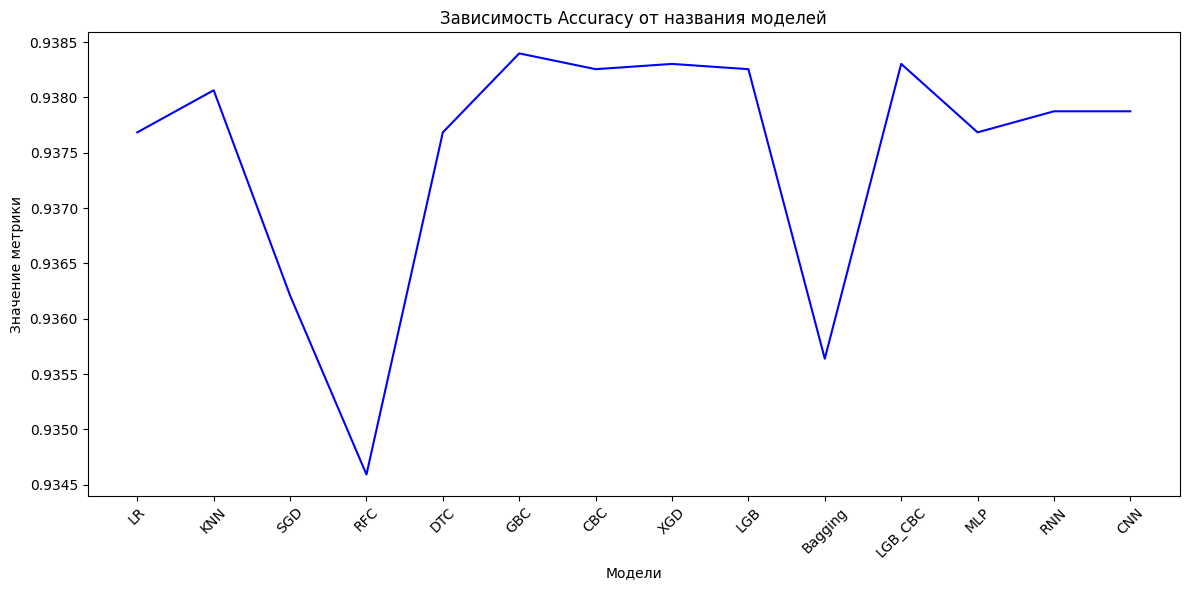

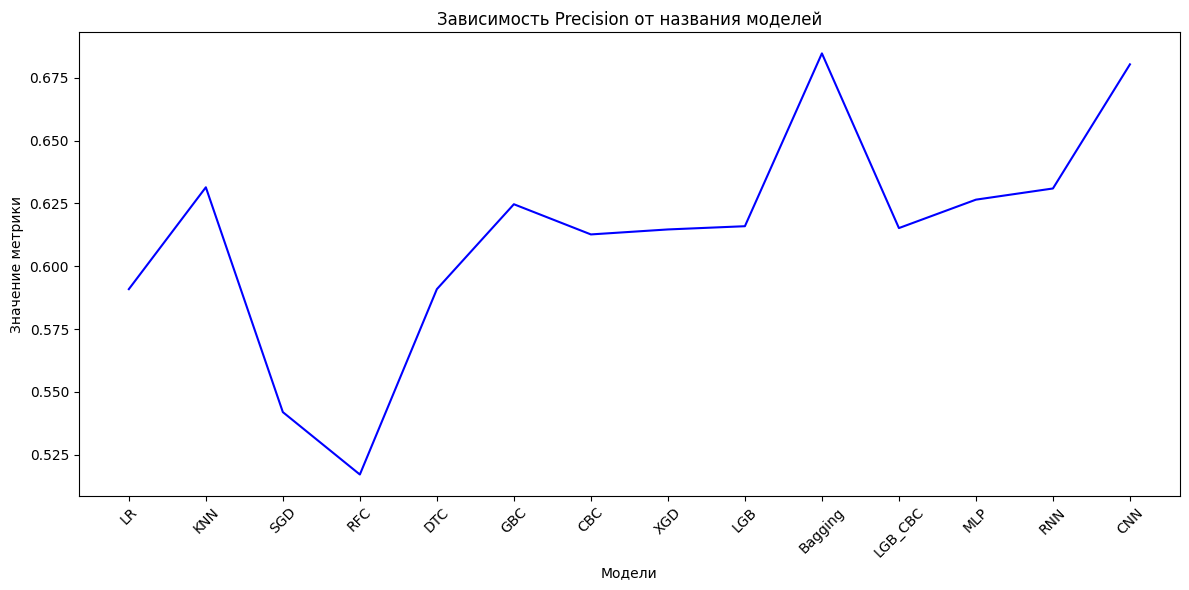

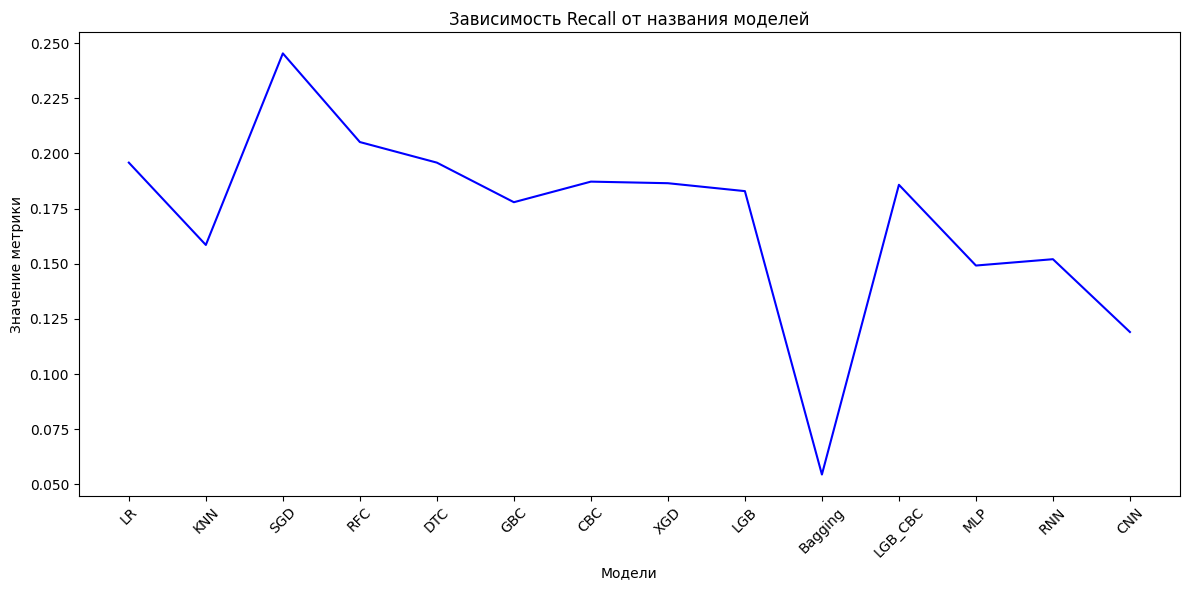

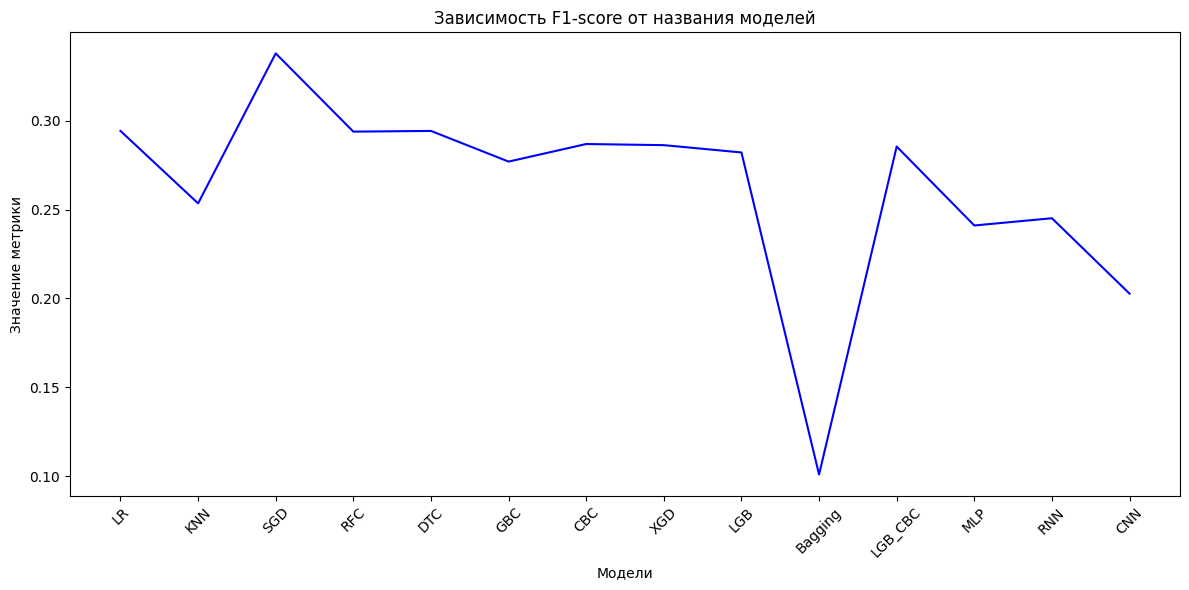

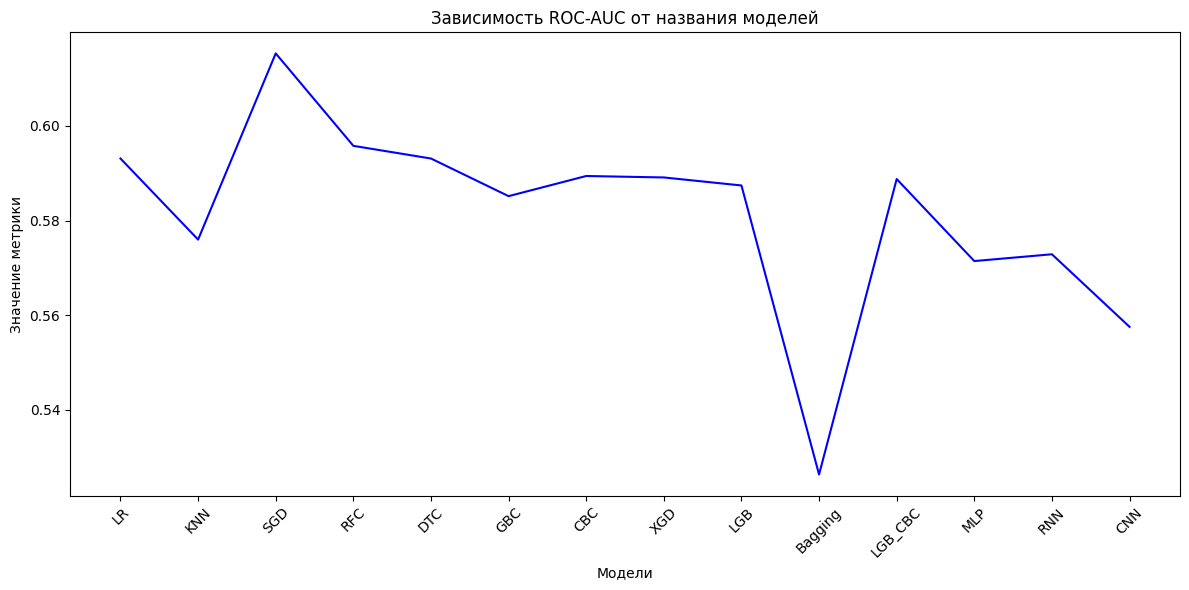

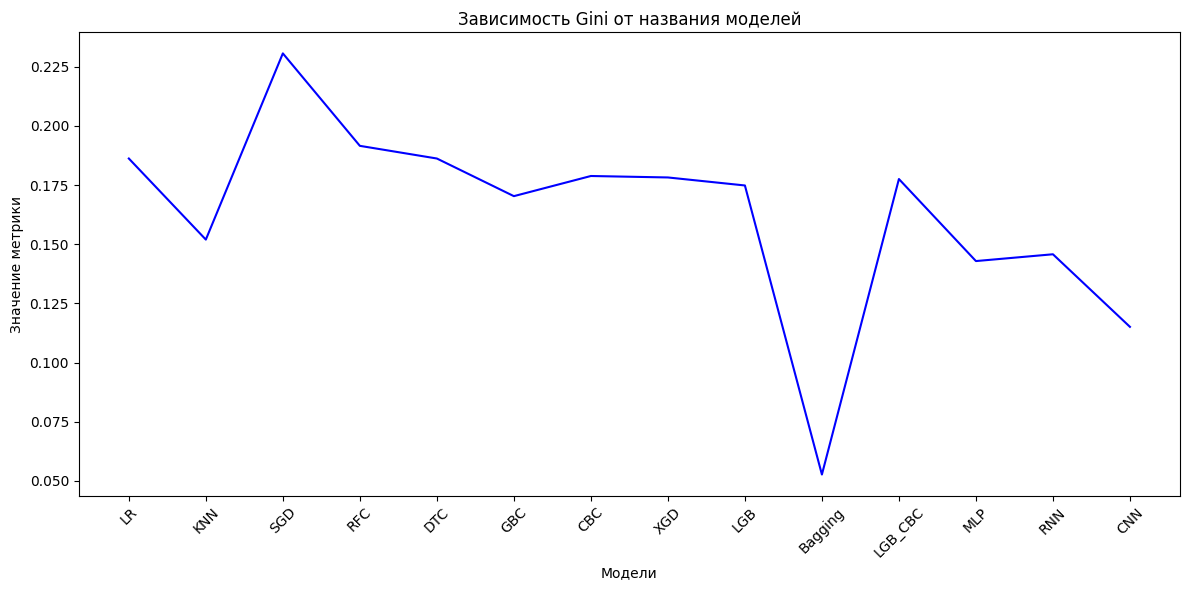

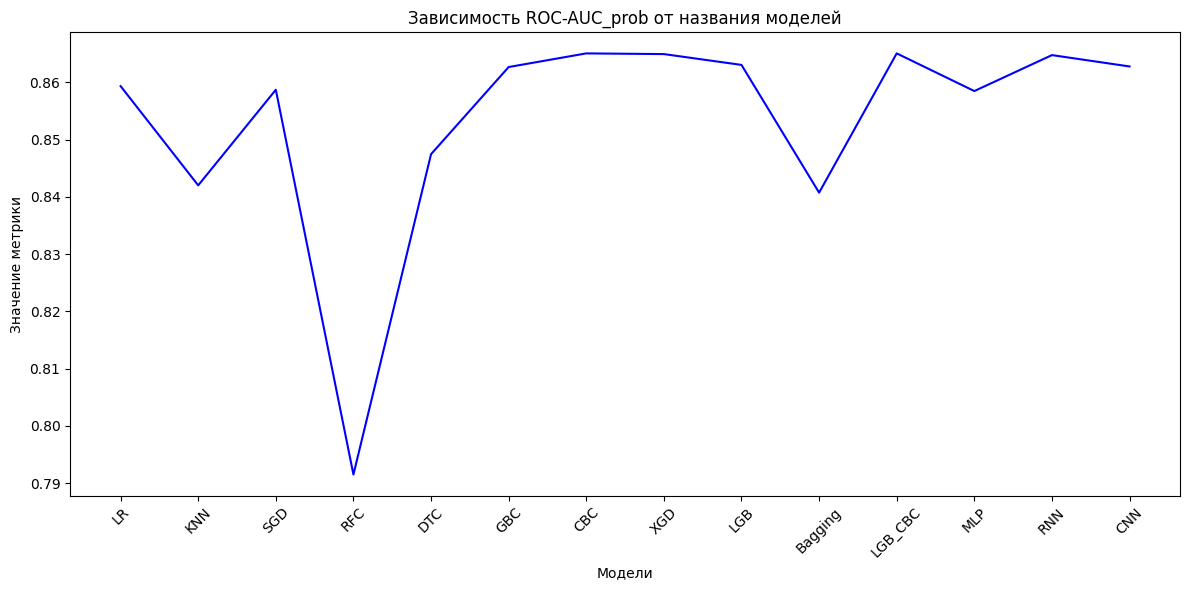

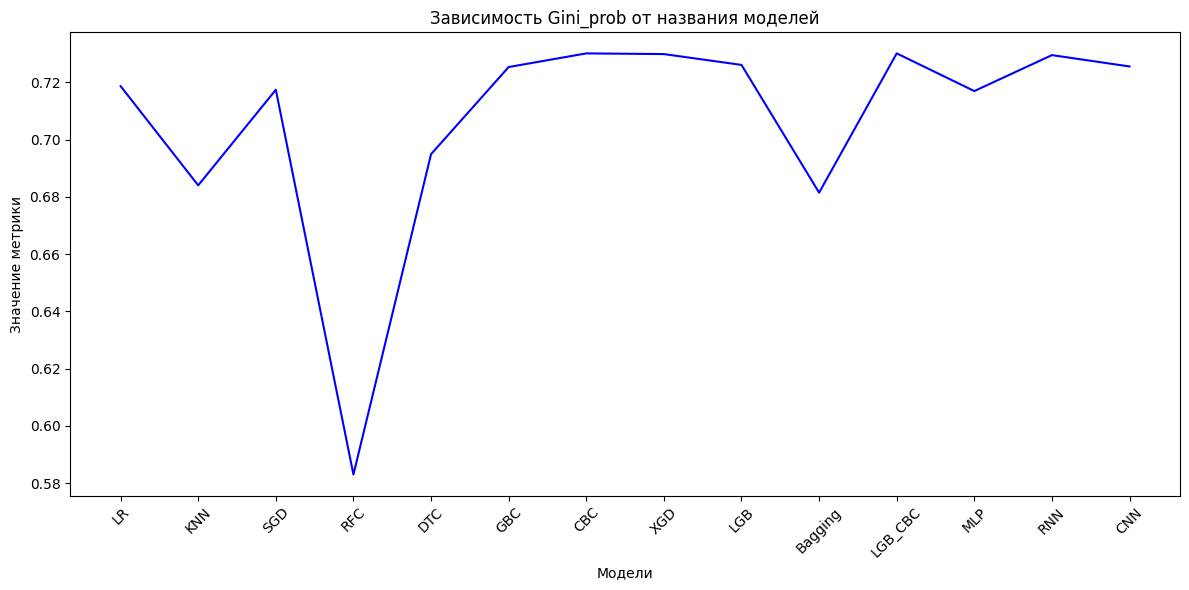

In [106]:
# Создание списков с метриками качества
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Gini', 'ROC-AUC_prob', 'Gini_prob']
values = result.loc[:, metrics].values
num_models = len(result)

# Создание списка с названиями моделей
models = result.index.values

# Построение отдельного графика для каждой метрики
for i in range(len(metrics)):
    plt.figure(figsize=(12, 6))

    # Построение графика для текущей метрики
    plt.plot(models, values[:, i], color='b')

    # Настройки графика
    plt.xticks(rotation=45)
    plt.xlabel('Модели')
    plt.ylabel('Значение метрики')
    plt.title(f'Зависимость {metrics[i]} от названия моделей')

    # Отображение графика
    plt.tight_layout()
    plt.show()

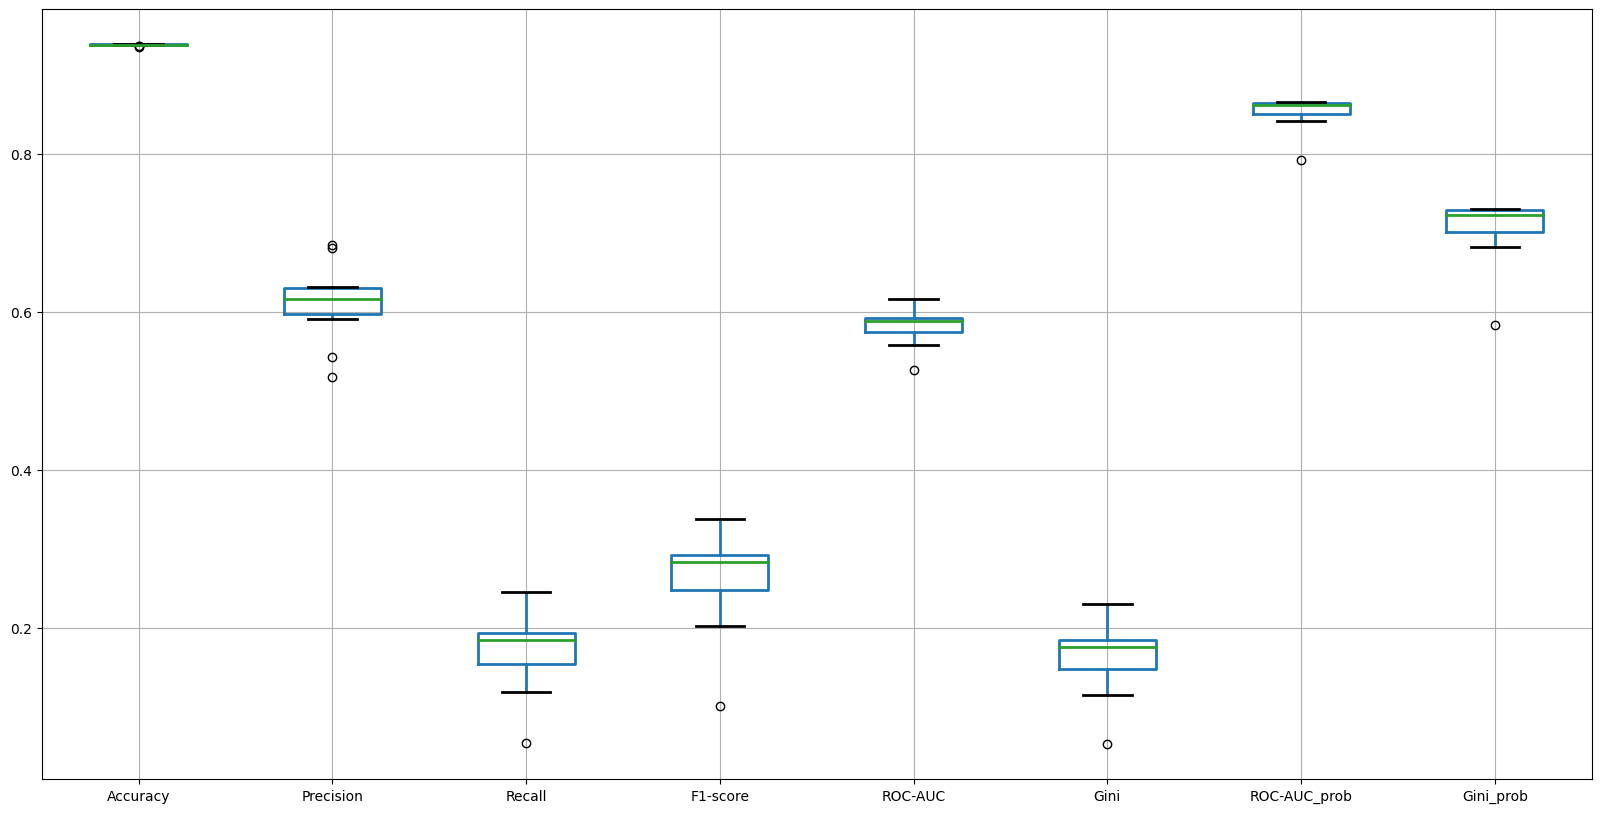

In [107]:
ax = result.boxplot(figsize=(20,10))
_ = plt.setp(ax.lines, linewidth=2.0)
plt.show()

# Валидация

Посмотрим на наше качество на кросс_валидации:

In [90]:
cv_score_logistic = cross_val_score(estimator=best_logistic_model, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_knn = cross_val_score(estimator=best_knn_model, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_sgd = cross_val_score(estimator=best_sgd_model, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_random_forest = cross_val_score(estimator=best_rfc_model, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_decision_tree = cross_val_score(estimator=decision_tree, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_gradient_boosting = cross_val_score(estimator=gradient_boosting, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_cat_boost_classifier = cross_val_score(estimator=cat_boost_classifier, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_xgb = cross_val_score(estimator=best_model_xgb, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_lgb = cross_val_score(estimator=best_model_lgb, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_bagging = cross_val_score(estimator=best_bagging_model, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_LGB_CBC = cross_val_score(estimator=best_LGB_CBC, X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')

0:	learn: 0.5594834	total: 13.4ms	remaining: 2.67s
1:	learn: 0.4572593	total: 27.8ms	remaining: 2.75s
2:	learn: 0.3904872	total: 40.6ms	remaining: 2.66s
3:	learn: 0.3354791	total: 53.2ms	remaining: 2.61s
4:	learn: 0.3000996	total: 65.7ms	remaining: 2.56s
5:	learn: 0.2728513	total: 78.9ms	remaining: 2.55s
6:	learn: 0.2523978	total: 92.1ms	remaining: 2.54s
7:	learn: 0.2369887	total: 106ms	remaining: 2.53s
8:	learn: 0.2253916	total: 119ms	remaining: 2.52s
9:	learn: 0.2172159	total: 132ms	remaining: 2.51s
10:	learn: 0.2102566	total: 146ms	remaining: 2.5s
11:	learn: 0.2056740	total: 159ms	remaining: 2.49s
12:	learn: 0.2015586	total: 171ms	remaining: 2.46s
13:	learn: 0.1977020	total: 184ms	remaining: 2.44s
14:	learn: 0.1950745	total: 197ms	remaining: 2.43s
15:	learn: 0.1928586	total: 210ms	remaining: 2.41s
16:	learn: 0.1911915	total: 229ms	remaining: 2.47s
17:	learn: 0.1900919	total: 243ms	remaining: 2.45s
18:	learn: 0.1889936	total: 256ms	remaining: 2.44s
19:	learn: 0.1879003	total: 268ms	r

In [ ]:
#cv_score_MLP = cross_val_score(estimator=KerasClassifier(model_MLP), X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
# cv_score_rnn = cross_val_score(estimator=KerasClassifier(model_rnn), X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
# cv_score_cnn = cross_val_score(estimator=KerasClassifier(model_cnn), X=X_train, y=y_train, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')

In [92]:
final_result = pd.DataFrame({'LR': cv_score_logistic,
                             'KNN': cv_score_knn,
                             'SGD': cv_score_sgd,
                             'RFC': cv_score_random_forest,
                             'DTC': cv_score_decision_tree,
                             'GBC': cv_score_gradient_boosting,
                             'CBC': cv_score_cat_boost_classifier,
                             'XGD': cv_score_xgb,
                             'LGB': cv_score_lgb,
                             'Bagging': cv_score_bagging,
                             'LGB_CBC': cv_score_LGB_CBC})
final_result

,LR,KNN,SGD,RFC,DTC,GBC,CBC,XGD,LGB,Bagging,LGB_CBC
0,0.856642,0.839289,0.856350,0.799854,0.840773,0.859548,0.863617,0.862768,0.862896,0.844813,0.864139
1,0.853281,0.842488,0.837934,0.798515,0.835878,0.859233,0.861683,0.860963,0.863230,0.843933,0.863227
2,0.844997,0.833714,0.843805,0.797851,0.832239,0.846591,0.849834,0.850156,0.851476,0.827950,0.851104
3,0.846339,0.832509,0.842777,0.792148,0.839635,0.851701,0.854807,0.853695,0.852591,0.838005,0.854521
4,0.855118,0.839168,0.851783,0.791893,0.835880,0.857287,0.861223,0.859767,0.859736,0.833594,0.861352
5,0.869969,0.852822,0.862886,0.802057,0.855063,0.874912,0.876278,0.875029,0.876896,0.846870,0.877374
6,0.853784,0.840197,0.846667,0.799328,0.843111,0.858504,0.861845,0.860510,0.862434,0.834876,0.862671


In [32]:
cv_score_logistic

array([0.85664194, 0.85328051, 0.84499701, 0.84633872, 0.85511773,
       0.86996891, 0.85378399])

In [37]:
cv_score_knn

array([0.83928921, 0.84248828, 0.83371391, 0.83250863, 0.83916845,
       0.85282174, 0.84019737])

In [42]:
cv_score_sgd

array([0.85634978, 0.83793362, 0.84380503, 0.84277661, 0.85178263,
       0.86288638, 0.84666721])

In [55]:
cv_score_random_forest

array([0.79985442, 0.79851458, 0.79785067, 0.79214782, 0.79189327,
       0.8020575 , 0.79932806])

In [60]:
cv_score_decision_tree

array([0.84077301, 0.83587845, 0.83223934, 0.83963467, 0.83587992,
       0.85506302, 0.84311053])

In [65]:
cv_score_gradient_boosting

array([0.85954792, 0.85923268, 0.84659103, 0.85170116, 0.85728696,
       0.87491214, 0.8585042 ])

In [70]:
cv_score_cat_boost_classifier

array([0.86361655, 0.86168329, 0.84983442, 0.85480736, 0.86122277,
       0.87627769, 0.86184489])

In [75]:
cv_score_xgb

array([0.86276756, 0.86096253, 0.85015602, 0.8536952 , 0.85976672,
       0.87502864, 0.86050965])

In [80]:
cv_score_lgb

array([0.86289646, 0.86322998, 0.85147581, 0.85259097, 0.8597359 ,
       0.87689576, 0.86243392])

In [85]:
cv_score_bagging

array([0.84481288, 0.84393339, 0.82795016, 0.83800503, 0.83359419,
       0.84687027, 0.83487583])

In [91]:
cv_score_LGB_CBC

array([0.86413891, 0.86322721, 0.851104  , 0.85452077, 0.86135185,
       0.87737367, 0.86267068])

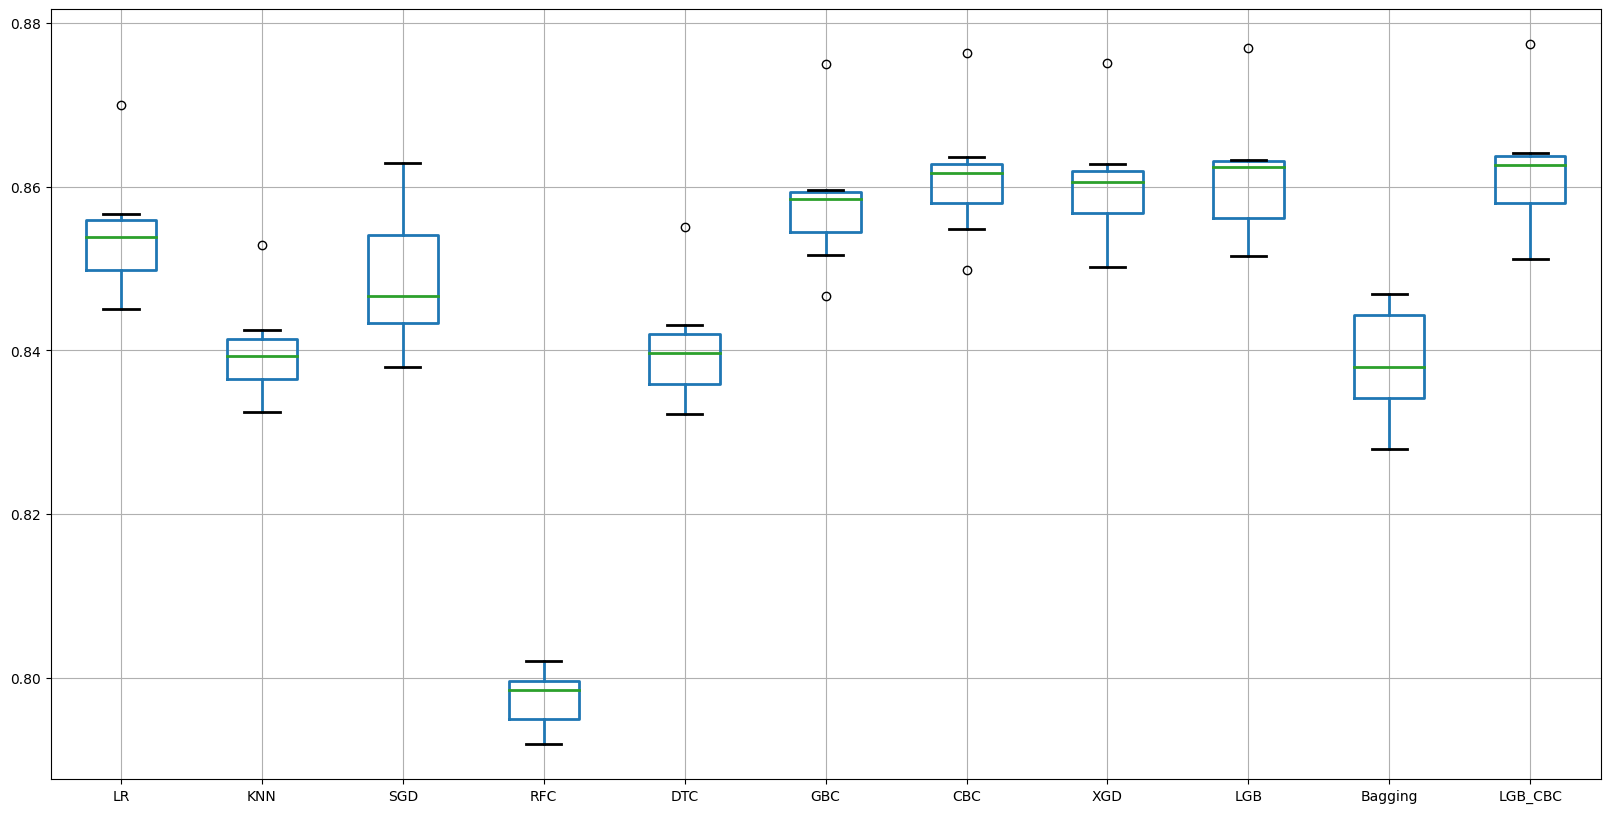

In [98]:
ax = final_result.boxplot(figsize=(20,10))
_ = plt.setp(ax.lines, linewidth=2.0)
plt.show()

Тест PSI

In [ ]:
def continuous2interval(df, df_target, percent_interval=0.1):
    special_target = []
    interval_target = []
    begin = False
    temp_percent = 0
    for index, row in (df[df_target].value_counts(normalize=True)).reset_index().sort_values(by='index').iterrows():
        if row[df_target] >= percent_interval:
            special_target.append(row['index'])
        else:
            temp_percent += row[df_target]
            if begin == False:
                begin = row['index']
            if temp_percent >= percent_interval:
                interval_target.append([begin, row['index']])
                begin = False
                temp_percent = 0
    if begin != False:
        interval_target.append([begin, np.inf])
    return interval_target, special_target

def PSI_factor_analysis(dev, val, column):
    intervals = [-np.inf] + [i[0] for i in continuous2interval(dev, column)[0]] + [np.inf]
    dev_temp = pd.cut(dev[column], intervals).value_counts()
    val_temp = pd.cut(val[column], intervals).value_counts()
    print('PSI:', sum(((dev_temp - val_temp)*np.log(dev_temp / val_temp)).replace([np.inf, -np.inf], 0)))
    plt.bar(np.arange(len(intervals)-1) - .15, dev_temp.values, width=0.3, label='Dev dataset')
    plt.bar(np.arange(len(intervals)-1) + .15, val_temp.values, width=0.3, label='Val dataset')
    plt.xticks(np.arange(len(intervals)-1), ['({}:{})'.format(i.left, i.right) for i in list(dev_temp.index)], rotation=90)
    plt.title('PSI for credits loans'.format(column))
    plt.legend()
    plt.show()

In [ ]:
PSI_factor_analysis(X_train, X_val,5)

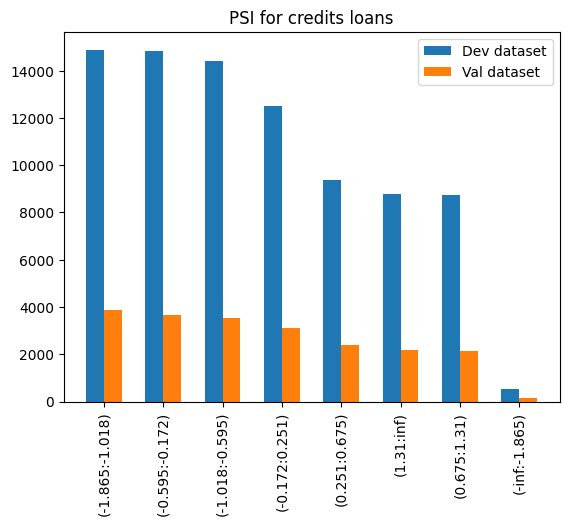

In [ ]:
PSI_factor_analysis(X_train, X_val,1)

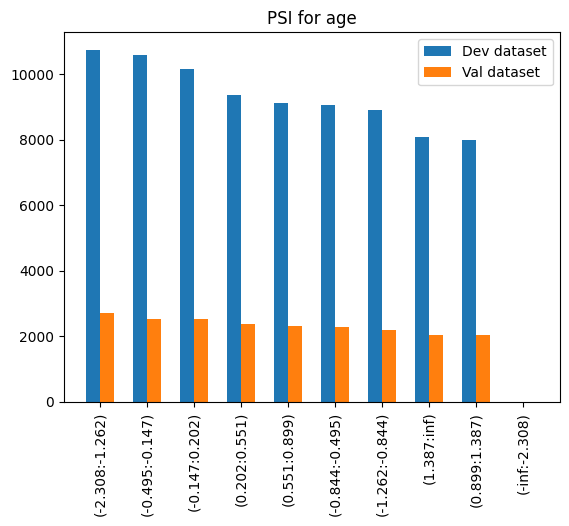

Исходный код алгоритмов, которые не были включены в исследование из-за долгого обучения

In [ ]:
# from sklearn.svm import SVC

# # Создание объекта модели SVM
# model_svm = SVC(probability=True)

# # Задание сетки гиперпараметров для перебора
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# # Создание объекта GridSearchCV
# grid_search_svm = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring='roc_auc', cv=5)

# # Обучение модели с перебором гиперпараметров и оценкой по метрике ROC-AUC
# grid_search_svm.fit(X_train, y_train)

# # Получение лучшей модели
# best_model_svm = grid_search_svm.best_estimator_

# # Предсказание вероятностей на тестовых данных
# y_pred_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

# # Вычисление ROC-AUC
# roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
# print("ROC-AUC (SVM):", roc_auc_svm)

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# # Создание базовых моделей
# base_models = [
#     ('logistic_regression', LogisticRegression()),
#     ('random_forest', RandomForestClassifier()),
#     ('decision_tree', DecisionTreeClassifier())
# ]

# # Создание модели стекинга с базовыми моделями
# stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# # Задание сетки гиперпараметров для подбора
# param_grid = {
#     'final_estimator__C': [0.1, 1.0, 10.0],
#     'random_forest__n_estimators': [100, 200, 300]
# }

# # Подбор оптимальных гиперпараметров для модели стекинга
# grid_search = GridSearchCV(stacking_model, param_grid=param_grid, scoring='roc_auc')
# grid_search.fit(X_train, y_train)

# # Получение лучшей модели после подбора
# best_stacking_model = grid_search.best_estimator_

# # Прогнозирование вероятностей на тестовых данных
# stacking_probs = best_stacking_model.predict_proba(X_test)[:, 1]

# # Вычисление ROC-AUC для модели
# roc_auc = roc_auc_score(y_test, stacking_probs)

# # Вывод метрики качества
# print("Stacking ROC-AUC:", roc_auc)

In [ ]:
# # Запускаем поиск лучших параметров alpha_1, alpha_2, alpha_3  на кроссвалидации
# GBC_CBC_XGB = GridSearchCV(estimator=VotingClassifier(estimators=[('GBC', gradient_boosting),
#                                                                   ('CBC', cat_boost_classifier),
#                                                                   ('XGB', best_model_xgb)], voting='soft'),
#                            param_grid={'weights': [[i,j, 1-i-j] for i in np.arange(0,1.1,0.1) for j in np.arange(0,1.1-i,0.1)]},
#                            cv=StratifiedKFold(shuffle=True, n_splits=10),
#                            scoring='roc_auc')
# GBC_CBC_XGB.fit(X_train, y_train)
# GBC_CBC_XGB.best_params_

In [ ]:
# GBC_CBC_XGB = GridSearchCV(estimator=VotingClassifier(estimators=[('GBC', gradient_boosting),
#                                                                   ('CBC', cat_boost_classifier),
#                                                                   ('XGB', best_model_xgb)],
#                                                       voting='soft'),
#                            param_grid={'weights': [[0.3, 0.4, 0.3]]},
#                            cv=StratifiedKFold(shuffle=True, n_splits=10),
#                            scoring='roc_auc')
# GBC_CBC_XGB.fit(X_train, y_train)
# GBC_CBC_XGB.score(X_test,y_test)